Qu'est-ce que ce notebook:
* feature engineering pour projet "émission CO2", 2024/2025 Polina Vincent Denis

Input (Pré-requis):
* Avoir téléchargé la base des ventes de véhicules européenne sur EEA, année 2022.  
    => sauvegardé sous data/eea_europa/data2022.csv
* Avoir traité data2022.csv avec denis_exploration_supprDoublons2022.ipynb 
    => cela vous a créé un fichier data/eea_europa/eaa2022_aggregationModeles.csv
* Disposer d'un fichier avec quelques classifications corrigées manuellement pour distinguer des véhicules vraiment 'petrol' de véhicules 'petrol/electric'  
  
Output:
* ce python vous crée un fichier data/eea_europa/data2022_feature_engineered.csv  
  
Versions:
* 05    - tâches Denis sauf vérifications de plausibilité entr'axes et consommation carburant
* 06    - vérification de plausibilité conso carburant
* 07    - debug
* 09VG2 - by Vincent : feature engineering puissance,
                       OHE Ft+Cr... 
* 10    - prise de temps pour évaluer la perf machine


In [2]:
%config IPCompleter.greedy=True

In [3]:
base_raw="../data/raw/"
base_processed="../data/processed/"

In [4]:
import time
start_time = time.time()

In [5]:
# !pip install pandas
import pandas as pd
df=pd.read_csv(base_processed+"eea2022_aggregationModeles.csv")

In [6]:
"""
# pour référence future si besoin
display(df[df['Cn'] == 'KRONOS 298 TL'][["m (kg)","W (mm)","At1 (mm)","At2 (mm)"]])
display(df_cleaned[df['Cn'] == 'KRONOS 298 TL'][["m (kg)","W (mm)","At1 (mm)","At2 (mm)"]])
"""

'\n# pour référence future si besoin\ndisplay(df[df[\'Cn\'] == \'KRONOS 298 TL\'][["m (kg)","W (mm)","At1 (mm)","At2 (mm)"]])\ndisplay(df_cleaned[df[\'Cn\'] == \'KRONOS 298 TL\'][["m (kg)","W (mm)","At1 (mm)","At2 (mm)"]])\n'

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1533693 entries, 0 to 1533692
Data columns (total 29 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   quantity             1533693 non-null  int64  
 1   Mk                   1533538 non-null  object 
 2   Cn                   1519854 non-null  object 
 3   Ft                   1533693 non-null  object 
 4   VFN                  1514052 non-null  object 
 5   Mp                   1455028 non-null  object 
 6   Mh                   1533693 non-null  object 
 7   Man                  1533689 non-null  object 
 8   Tan                  1528056 non-null  object 
 9   T                    1532703 non-null  object 
 10  Va                   1529369 non-null  object 
 11  Ve                   1518896 non-null  object 
 12  Ct                   1532531 non-null  object 
 13  Cr                   1533677 non-null  object 
 14  m (kg)               1533659 non-null  float64
 15

Nous supprimons les colonnes suivantes:  
* Colonnes vides ou mono-modales:
    * MMS  
    * r  
    * Ernedc  
    * De
    * Vf
    * Status
    * Year
    * ech
    * RLFI
* Colonnes non significatives pour l'émission de CO2:
    * Date of registration
    * Country
    * ID
    * quantity
* Colonnes contenant des codes non exploitables
    * VFN : identification par constructeur
    * Tan : id
    * T : type indiqué par constructeur
* Autres colonnes non explicatives
    * Enedc (g/km) : il s'agit de calcul d'émissioin de CO2 selon l'ancienne norme
    * Cn, Mp, Mh, Man, Mk : les noms des fabricants/groupes du modèle ne doivent pas influer sur l'explication
    * Va, Ve : noms de variantes par constructeur
    * Ct
* Colonnes redondantes ou trop liées
    * Mt : liée à m, mais m n'a pas de valeur manquante
    * Fuel consumption : trop liée à l'émission de CO2 (conséquence et pas cause)
    * 

En outre, on peut se poser la question à propos de : 
* Cr : categorie transport de personnes ou fret. Bon, ça doit influer mais faut-il la garder ? dans le doute on garde.

In [9]:
columns_to_drop = ['MMS', 'r', 'Ernedc', 'De', 'Vf', 'Status', 'Year', 'ech', 'RLFI',
                   'ID', 'Date of registration', 'Country', 'quantity',
                   'VFN', 'Tan', 'T',
                   'Enedc (g/km)',
                   'Mp', 'Mh', 'Man', 'Mk',
                   'Va', 'Ve',
                   'Ct',
                   'Mt', 'Fuel consumption '
                  ]
df_cleaned = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

In [10]:
display(df_cleaned.columns)

Index(['Cn', 'Ft', 'Cr', 'm (kg)', 'Ewltp (g/km)', 'W (mm)', 'At1 (mm)',
       'At2 (mm)', 'Fm', 'ec (cm3)', 'ep (KW)', 'z (Wh/km)', 'IT',
       'Erwltp (g/km)', 'Electric range (km)'],
      dtype='object')

***
On garde les 4 types d'énergie qui nous intéressent dans cette étude

In [12]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1533693 entries, 0 to 1533692
Data columns (total 15 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   Cn                   1519854 non-null  object 
 1   Ft                   1533693 non-null  object 
 2   Cr                   1533677 non-null  object 
 3   m (kg)               1533659 non-null  float64
 4   Ewltp (g/km)         1531121 non-null  float64
 5   W (mm)               1527183 non-null  float64
 6   At1 (mm)             1485917 non-null  float64
 7   At2 (mm)             1483597 non-null  float64
 8   Fm                   1533668 non-null  object 
 9   ec (cm3)             1397137 non-null  float64
 10  ep (KW)              1519217 non-null  float64
 11  z (Wh/km)            313937 non-null   float64
 12  IT                   987344 non-null   object 
 13  Erwltp (g/km)        941541 non-null   float64
 14  Electric range (km)  277677 non-null   float64
dty

In [13]:
df_cleaned['Fm'].value_counts()

Fm
M    876150
H    334507
P    181568
E    136454
B      4534
F       455
Name: count, dtype: int64

In [14]:

# valeurs de 'Ft' qu'on veut garder pour l'étude
energie_etude = ['petrol', 'diesel', 'petrol/electric', 'diesel/electric']

# 2. Filtrer le DataFrame pour garder seulement les lignes où 'Ft' est dans la liste des valeurs acceptées
df_cleaned = df_cleaned[df['Ft'].isin(energie_etude)]


In [15]:
# Compter les lignes avec au moins une valeur NaN dans les colonnes spécifiées
num_nan_rows = df_cleaned[['W (mm)', 'At1 (mm)', 'At2 (mm)']].isna().any(axis=1).sum()

# Calculer le pourcentage de ces lignes par rapport au total des lignes
percentage_nan_rows = (num_nan_rows / len(df_cleaned)) * 100

print(percentage_nan_rows)


3.3298334109089334


On a donc 3% des vehicules auxquels il manque des valeurs d'espacement des roues.  
On va enlever ces lignes


In [17]:
df_cleaned = df_cleaned.dropna(subset=['W (mm)', 'At1 (mm)', 'At2 (mm)'])

***
Maintenant on cherche les anomalies

In [19]:
# on vérifie les extrêmes de la masse
bas = df_cleaned['m (kg)'].quantile(0.00001)
haut = df_cleaned['m (kg)'].quantile(0.99999)

# Identifier les outliers
outliers = df_cleaned[(df_cleaned['m (kg)'] < bas) | (df_cleaned['m (kg)'] > haut)]

# Afficher les outliers mais aussi avec des colonnes du fichier initial df:
outliers_with_original = df.loc[outliers.index]
outliers_sorted = outliers_with_original.sort_values(by='m (kg)')
cols = ['m (kg)', 'ec (cm3)'] + [col for col in outliers_sorted.columns if col not in ['m (kg)', 'quantity', 'Man', 'Mp','Tan', 'ec (cm3)']]
outliers_sorted = outliers_sorted[cols]
display(outliers_sorted)
print(len(outliers_with_original))


,m (kg),ec (cm3),Mk,Cn,Ft,VFN,Mh,T,Va,Ve,...,W (mm),At1 (mm),At2 (mm),Fm,ep (KW),z (Wh/km),IT,Erwltp (g/km),Fuel consumption,Electric range (km)
77034,570.0,658.0,CATERHAM,SEVEN S3,petrol,IP-ZA5_20210001-SDK-1,CATERHAM,SevenS3,ZA,5,...,2225.0,1220.0,1301.0,M,62.0,NaN,NaN,NaN,4.8,NaN
1354229,570.0,658.0,CATERHAM,SEVEN S3,petrol,IP-ZA5_20210001-SDK-1,CATERHAM,SEVEN S3,ZA,5,...,2225.0,1220.0,1301.0,M,63.0,NaN,NaN,NaN,4.9,NaN
1354228,570.0,658.0,CATERHAM,SEVEN S3,petrol,IP-ZA5_20210001-SDK-1,CATERHAM,SEVEN S3,ZA,5,...,2225.0,1220.0,1301.0,M,63.0,NaN,NaN,NaN,4.8,NaN
244167,570.0,658.0,CATERHAM,SEVEN S3,petrol,IP-ZA5_20210001-SDK-1,CATERHAM,SEVEN S3,ZA,5,...,2225.0,1220.0,1301.0,M,63.0,NaN,NaN,NaN,4.8,NaN
1278778,570.0,658.0,CATERHAM CARS LTD,SEVEN S3 (ZA VARIANT),petrol,IP-ZA5_20010001-SDK-1,CATERHAM,SEVENS3,ZA,5,...,2225.0,1220.0,1301.0,M,63.0,NaN,NaN,NaN,NaN,NaN
1035401,570.0,658.0,CATERHAM,Seven S3 (ZA Variant),petrol,NaN,CATERHAM,SEVEN S3,ZA,5,...,2225.0,1220.0,1301.0,M,63.0,NaN,NaN,NaN,NaN,NaN
783533,570.0,658.0,CATERHAM CARS LTD,SEVEN S3,petrol,IP-ZA5_20210001-SDK-1,CATERHAM,SEVEN S3,ZA,5,...,2230.0,1220.0,1300.0,M,63.0,NaN,NaN,NaN,4.8,NaN
1354481,580.0,1000.0,SUPER 7,MK INDY R KOPIA,petrol,NaN,AA-IVA,NaN,NaN,NaN,...,2370.0,1560.0,1530.0,M,96.0,NaN,NaN,NaN,NaN,NaN
1354827,580.0,1600.0,JA37,NaN,petrol,NaN,AA-IVA,NaN,NaN,NaN,...,2200.0,1255.0,1340.0,M,62.0,NaN,NaN,NaN,NaN,NaN
1085073,645.0,658.0,CATERHAM,SEVEN S3,petrol,EV-2019_001_SDK-1,CATERHAM,SEVEN S3,ZA,5,...,2225.0,1335.0,1335.0,M,63.0,NaN,NaN,NaN,4.8,NaN


23


Cette liste des extrêmes est réaliste au vu des modèles

On doit juste corriger l'Audi A8 4l et Mercedes S600+S680 6l qui pèsent 2,5 t et pas 4 t 

In [22]:
df_cleaned.loc[df_cleaned['m (kg)'] == 3950, "m (kg)"]=2500
df_cleaned.loc[df_cleaned['m (kg)'] == 4160, "m (kg)"]=2500
df_cleaned.loc[df_cleaned['m (kg)'] == 4255, "m (kg)"]=2500

# juste une vérification
df_cleaned[df_cleaned['m (kg)'] == 3950]

,Cn,Ft,Cr,m (kg),Ewltp (g/km),W (mm),At1 (mm),At2 (mm),Fm,ec (cm3),ep (KW),z (Wh/km),IT,Erwltp (g/km),Electric range (km)


On s'intéresse maintenant aux classifications suspectes en petrol, de modèles émettant peu de CO2.  

Chez les Smart fortwo essence, même la 60cv émet 104g / km  
https://www.mobile.de/auto/smart/fortwo/2014/zweituerer/modell/daten-fakten/  
ici, l'index 743235, il s'agit d'une 71cv (52KW) donc elle émet 110g/km

In [25]:
# Filtrer les lignes avec les conditions spécifiques 
filtered_df = df.loc[(df['m (kg)'] == 750.0) & (df['Ewltp (g/km)'] == 78.0) ]

# Afficher les lignes filtrées, il ne doit y avoir que la Smart en question
print(filtered_df)

         quantity     Mk      Cn      Ft  VFN             Mp  \
1127710         1  SMART  FORTWO  petrol  NaN  MERCEDES-BENZ   

                       Mh               Man Tan    T  ... At1 (mm) At2 (mm)  \
1127710  MERCEDES-BENZ AG  MERCEDES-BENZ AG  ND  NaN  ...   1450.0   1455.0   

        Fm ec (cm3)  ep (KW)  z (Wh/km)   IT  Erwltp (g/km)  \
1127710  M    999.0     52.0        NaN  NaN            NaN   

         Fuel consumption   Electric range (km)  
1127710                NaN                  NaN  

[1 rows x 29 columns]


In [26]:
# On corrige la Smart fortwo mal saisie
mask = (df['m (kg)'] == 750.0) & (df['Ewltp (g/km)'] == 78.0)
df.loc[mask, 'Ewltp (g/km)'] = 110.0


In [27]:
lowest_ewltp_vehicles = df_cleaned[(df_cleaned['Ewltp (g/km)'] < 100) & (df_cleaned['Ft'] == 'petrol')]
lowest_ewltp_values = df.loc[lowest_ewltp_vehicles.index, ['Cn', 'Ft', 'Cr', 'm (kg)', 'Ewltp (g/km)', 'W (mm)', 'At1 (mm)', 'At2 (mm)', 'Fm', 'ec (cm3)', 'ep (KW)', 'z (Wh/km)', 'IT', 'Erwltp (g/km)', 'Electric range (km)']]
 
# Trier par ordre croissant de 'Ewltp (g/km)'
lowest_ewltp_values_sorted = lowest_ewltp_values.sort_values(by='Ewltp (g/km)')

# Grouper par 'Cn' et 'Ewltp (g/km)' et garder la première occurrence de chaque, afin de faire des recherches manuelles sur les modèles
lowest_ewltp_values_grouped = lowest_ewltp_values_sorted.drop_duplicates(subset=['Cn', 'Ewltp (g/km)'])
display(lowest_ewltp_values_grouped)

,Cn,Ft,Cr,m (kg),Ewltp (g/km),W (mm),At1 (mm),At2 (mm),Fm,ec (cm3),ep (KW),z (Wh/km),IT,Erwltp (g/km),Electric range (km)
471410,TX,petrol,M1,2305.0,19.0,2985.0,1620.0,1625.0,H,1477.0,67.0,NaN,NaN,NaN,NaN
1305844,SPORTAGE,petrol,M1G,1905.0,25.0,2680.0,1615.0,1622.0,H,1598.0,132.0,NaN,NaN,NaN,NaN
711566,A6 55 TFSI e,petrol,M1,2175.0,28.0,2931.0,1634.0,1627.0,M,1984.0,195.0,NaN,NaN,NaN,NaN
706988,FORMENTOR E-HYBRID,petrol,M1,1703.0,29.0,2679.0,1585.0,1559.0,M,1395.0,110.0,NaN,NaN,NaN,NaN
715510,A3 40 TFSIe,petrol,M1,1676.0,29.0,2618.0,1557.0,1544.0,M,1395.0,110.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190234,TOYOTA PRIUS,petrol,M1,1515.0,99.0,2700.0,1530.0,1545.0,H,1798.0,72.0,NaN,e6 37,0.80,NaN
1256549,TOYOTA COROLLA,petrol,M1,1462.0,99.0,2700.0,1537.0,1537.0,H,1798.0,72.0,NaN,NaN,NaN,NaN
1300295,COROLLA,petrol,M1,1456.0,99.0,2700.0,1530.0,1530.0,H,1798.0,72.0,NaN,NaN,NaN,NaN
415089,I10,petrol,M1,996.0,99.0,2425.0,1467.0,1478.0,M,998.0,49.0,NaN,e5 29,1.03,NaN


In [28]:
# Sélectionner les colonnes qui seront intéressantes pour la recherche manuelle
columns_to_save = ['Cn', 'Ft', 'm (kg)', 'Ewltp (g/km)', 'ec (cm3)', 'ep (KW)', 'z (Wh/km)', 'Electric range (km)']
selected_columns = lowest_ewltp_values_grouped[columns_to_save]

# Sauvegarder dans un fichier CSV
selected_columns.to_csv(base_processed+'petrol_low_ewltp_values_grouped.csv', index=False)

On regarde tous ces modèles via le fichier csv. Ce sont tous des hybrides !  
On doit donc la classer dans les petrol/electric.  
Ci-dessous, on garde trace des preuves.  

***  


Fiat 500:    
https://www.car-emissions.com/cars/index/fiat%20500%201.2%20/page:1/sort:CO2_gkm/direction:asc  
nous confirme que les modèles essence les moins émetteurs de fiat 500 émettent >= 100 g/km


   
La Corolla même en 72 KW est encore une hybride:  
https://autodiiler.ee/en/vehicles/26022

Mercedes GLC 300e est une hybride, même  si c'est difficile à croire d'ailleurs qu'elle émette seulement 12g/km de CO2, mais ce sont des donées officielles.     
https://www.avem.fr/wp-content/uploads/2020/12/mercedes_glc_300e_4matic_coupe.jpg   

 
LEVC (London *Electric Vehicle* Company) est aussi au mieux un hybride.  

KIA sportage : même sur le site constructeur, on est jamais en dessous de 128 g/km WLTP  
https://www.kia.com/uk/new-cars/sportage/specification/


Audi A6 55 TFSI e : c'est une hybride rechargeable
https://www.audi.fr/fr/gamme/a6/a6-avant-tfsi-e/

TFSI e c'est une hybride  
CUPRA E-Hybrid c'est évident

La Volvo XC90 est toujours >150g/km en energie fossile. les <100g sont des hybrides:  
http://www.larevueautomobile.com/fiche-technique-auto/Caracteristique-volvo-xc90-t8-awd-twin-engine-2020


la seule KIA MQ4 qui émet 36g/km de CO2, c'est l'hybride:  
https://www.motorimdetail.de/pa/kia-sorento-1-6-t-gdi-plug-in-hybrid-vision-awd-automatic-2021

KIA Sorento 1.6 T-GDI Plug-in-Hybrid Vision AWD Automatic 2021

il n'y a pas de secret, les seules golf < 100g/km sont hybrides.  
http://www.larevueautomobile.com/fiche-technique-auto/rejet-de-co2/Volkswagen_Golf


C'est impossible, même la version moins puissante fait minimum 141 g / km  
https://www.media.volvocars.com/global/en-gb/models/xc40/2023/specifications  
à part supprimer cette ligne, je ne vois pas de correction possible.


Volvo XC60 jamais en dessous de 174g/km, sauf hybride  


Yaris: probablement l'hybride suivante,
https://www.autoscout24.de/auto/technische-daten/toyota/yaris/yaris-hybrid-1-5-vvt-i-seit-2020-limousine-benzin-elektro/

Lexus CT200H, vendue uniquement en hybride  
https://www.mobile.de/auto/lexus/ct/serie/?srsltid=AfmBOooNpsp8x_zIF0lyCvdiNSjVbuWkHM56nEWul0c8dch-wbHQ7r_E

hybride:  
https://www.toyota.fr/content/dam/toyota/nmsc/france/informations/loi-climat/2024/01-janvier/tableau-CO2-toyota-01-2024.pdf

In [44]:
# on met Ft=petrol/electric pour toutes les lignes de lowest_ewltp_vehicles
df_cleaned.loc[lowest_ewltp_vehicles.index, 'Ft'] = 'petrol/electric'

# on vérifie que maintenant il n'y a plus de lignes avec Ft=petrol pour des valeurs de Ewltp < 100
lowest_ewltp_vehicles_after = df_cleaned[(df_cleaned['Ewltp (g/km)'] < 100) & (df_cleaned['Ft'] == 'petrol')]
len(lowest_ewltp_vehicles_after)

0

On a reclassé tous les <100  
On se doute bien que dans la range 100<x<110, il y aura aussi des hybrides placés par erreur

In [46]:
# Sélectionner les véhicules ayant 'Ewltp (g/km)' entre 101 et 110 et 'Ft' == 'petrol'
upto110_ewltp_vehicles = df_cleaned[(df_cleaned['Ewltp (g/km)'] > 100) & (df_cleaned['Ewltp (g/km)'] <= 110) & (df_cleaned['Ft'] == 'petrol')]
upto110_ewltp_values = df.loc[upto110_ewltp_vehicles.index, ['Cn', 'Ft', 'Cr', 'm (kg)', 'Ewltp (g/km)', 'W (mm)', 'At1 (mm)', 'At2 (mm)', 'Fm', 'ec (cm3)', 'ep (KW)', 'z (Wh/km)', 'IT', 'Erwltp (g/km)', 'Electric range (km)']]

# Trier par ordre croissant de 'Ewltp (g/km)'
upto110_ewltp_vehicles_sorted = upto110_ewltp_values.sort_values(by='Ewltp (g/km)')

# On veut créer un fichier pour faire des vérifications "manuelles" sur les modèles
# Grouper par 'Cn' et 'Ewltp (g/km)' et garder la première occurrence
upto110_ewltp_vehicles_grouped = upto110_ewltp_vehicles_sorted.drop_duplicates(subset=['Cn', 'm (kg)', 'Ewltp (g/km)', 'ec (cm3)', 'ep (KW)'])

# Sélectionner les colonnes qui seront intéressantes pour la recherche manuelle
columns_to_save = ['Cn', 'Ft', 'm (kg)', 'Ewltp (g/km)', 'ec (cm3)', 'ep (KW)', 'z (Wh/km)', 'Electric range (km)']
upto110_selected_columns = upto110_ewltp_vehicles_grouped[columns_to_save]

# Sauvegarder dans un fichier CSV. On met l'index pour pouvoir retrouver les lignes dans le fichier initial
upto110_selected_columns.to_csv(base_processed+'petrol_100_110_ewltp_grouped.csv', index=True)

In [47]:
print (f"on a {len(upto110_ewltp_vehicles)} véhicules petrol avec Ewltp entre 100 et 110")
print (f"on a {len(upto110_ewltp_vehicles_grouped)} véhicules petrol uniques sur subset choisi, avec Ewltp entre 100 et 110")
print(f"On devra mettre à jour la nouvelle classe sur les {len(upto110_ewltp_vehicles)} véhicules")

on a 7118 véhicules petrol avec Ewltp entre 100 et 110
on a 562 véhicules petrol uniques sur subset choisi, avec Ewltp entre 100 et 110
On devra mettre à jour la nouvelle classe sur les 7118 véhicules


L'étude de ces modèles "à la main" montre que la plupart sont aussi des hybrides, 
mais on a pu trouver quelques essence,  
on va faire travailler un modèle pour les re-classer

on va dans la suite:  
* ajouter au fichier un ft_checked et un reference  
* lire le fichier
* faire travailler le randomForest
* mettre la classe Ft estimée dans df_cleaned
* sauvegarder df_cleaned sous un nouveau nom proche du fichier initial

 On a ajouté à la main dans le fichier petrol_100_110_ewltp_grouped_checked 2 nouvelles colonnes : "Ft_checked" et "reference" (pour info)  
 pour quelques vehicules vérifiés

In [51]:
# fait une seule fois pour vérifier
"""
# lire le fichier 'petrol_100_110_ewltp_grouped.csv' avec index
df_petrol_100_110_ewltp_grouped = pd.read_csv('data/eea_europa/petrol_100_110_ewltp_grouped_checked.csv', index_col=0)

# on vérifie que le nombre de lignes est le même que dans le fichier initial
len(df_petrol_100_110_ewltp_grouped)
"""

"\n# lire le fichier 'petrol_100_110_ewltp_grouped.csv' avec index\ndf_petrol_100_110_ewltp_grouped = pd.read_csv('data/eea_europa/petrol_100_110_ewltp_grouped_checked.csv', index_col=0)\n\n# on vérifie que le nombre de lignes est le même que dans le fichier initial\nlen(df_petrol_100_110_ewltp_grouped)\n"

In [52]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# Charger les données éditées à la main
df_110_checked = pd.read_csv(base_raw+'petrol_100_110_ewltp_grouped_checked.csv')

# Définir les colonnes explicatives
feature_columns = ['m (kg)', 'Ewltp (g/km)', 'ec (cm3)', 'ep (KW)']

# Séparer les lignes avec des classes connues et inconnues
known_classes = df_110_checked[df_110_checked['Ft_checked'].notna()]
unknown_classes = df_110_checked[df_110_checked['Ft_checked'].isna()]

# Préparer les features et la target pour les lignes avec des classes connues
X_known = known_classes[feature_columns]
y_known = known_classes['Ft_checked']

# Préparer les features pour les lignes avec des classes inconnues
X_unknown = unknown_classes[feature_columns]

# Entraîner un modèle RandomForestClassifier
model = RandomForestClassifier(random_state=42)
print("on entraîne à partir de ", len(X_known), "lignes vérifiées")
model.fit(X_known, y_known)

# Prédire les classes pour les lignes avec des classes inconnues
unknown_classes['Ft_new'] = model.predict(X_unknown)

# placer dans df_110_checked['Ft'] les valeurs connues de 'Ft_checked', c'est notre point de départ
df_110_checked['Ft'] = df_110_checked['Ft_checked']

# Remplacer les valeurs de la colonne Ft par les nouvelles prédictions
df_110_checked.loc[unknown_classes.index, 'Ft'] = unknown_classes['Ft_new']

# Sauvegarder le DataFrame mis à jour dans un fichier CSV si on veut comparer l'avant/après visuellement
df_110_checked.to_csv(base_processed+'up_to_110_petrol_classified_vehicles_RF.csv', index=False)

on entraîne à partir de  46 lignes vérifiées


C:\Users\abcd3\AppData\Local\Temp\ipykernel_29620\1163080183.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unknown_classes['Ft_new'] = model.predict(X_unknown)


In [53]:
import numpy as np

# Maintenant on met dans 'Ft' les classes estimées par le modèle
# Définir les colonnes pour la jointure (rappel: df_cleaned ne connait pas Cn)
join_columns = ['m (kg)', 'Ewltp (g/km)', 'ec (cm3)', 'ep (KW)']


# Effectuer une jointure pour obtenir les valeurs de 'Ft' de df_110_checked dans df_cleaned
df_110_checked_deduped = df_110_checked.drop_duplicates(subset=join_columns)
df_merged = df_cleaned.merge(df_110_checked_deduped[join_columns + ['Ft']], on=join_columns, how='left', suffixes=('', '_checked'))

# Placer les valeurs de 'Ft' de df_110_checked dans 'Ft_new' de df_cleaned, surtout ne pas procéder selon index
df_cleaned['Ft_new'] = df_merged['Ft_checked'].values

# Remplacer les valeurs de Ft par celles de Ft_new seulement quand Ft_new n'est pas NaN
df_cleaned['Ft'] = np.where(df_cleaned['Ft_new'].notna(), df_cleaned['Ft_new'], df_cleaned['Ft'])

# Sauvegarde de sécurité du DataFrame mis à jour
df_cleaned.to_csv(base_processed+'temp_df_cleaned_with_Ft_new.csv', index=False)


In [54]:
display(df_cleaned[df_cleaned["Ewltp (g/km)"]<111].head(5))

,Cn,Ft,Cr,m (kg),Ewltp (g/km),W (mm),At1 (mm),At2 (mm),Fm,ec (cm3),ep (KW),z (Wh/km),IT,Erwltp (g/km),Electric range (km),Ft_new
2,MITSUBISHI ECLIPSE CROSS,petrol/electric,M1,1975.0,46.0,2670.0,1540.0,1540.0,P,2360.0,72.0,175.0,NaN,NaN,45.0,NaN
4,TOYOTA AYGO X,petrol/electric,M1,1020.0,108.0,2430.0,1540.0,1520.0,M,998.0,53.0,NaN,NaN,NaN,NaN,petrol/electric
8,SPORTAGE,petrol/electric,M1,1905.0,25.0,2680.0,1615.0,1622.0,P,1598.0,132.0,169.0,NaN,NaN,70.0,NaN
9,SPORTAGE,petrol/electric,M1,1905.0,25.0,2680.0,1615.0,1622.0,P,1598.0,132.0,169.0,NaN,NaN,70.0,NaN
18,SPORTAGE,petrol/electric,M1,1905.0,25.0,2680.0,1615.0,1622.0,P,1598.0,132.0,169.0,NaN,NaN,70.0,NaN


On a re-classé les 100->110  
Maintenant on va regarder les diesel de la même façon  

In [56]:
lowest_ewltp_vehicles = df_cleaned[(df_cleaned['Ewltp (g/km)'] < 100) & (df_cleaned['Ft'] == 'diesel')]
lowest_ewltp_values = df.loc[lowest_ewltp_vehicles.index, ['Cn', 'Ft', 'Cr', 'm (kg)', 'Ewltp (g/km)', 'W (mm)', 'At1 (mm)', 'At2 (mm)', 'Fm', 'ec (cm3)', 'ep (KW)', 'z (Wh/km)', 'IT', 'Erwltp (g/km)', 'Electric range (km)']]
 
# Trier par ordre croissant de 'Ewltp (g/km)'
lowest_ewltp_values_sorted = lowest_ewltp_values.sort_values(by='Ewltp (g/km)')

# Grouper par 'Cn' et 'Ewltp (g/km)' et garder la première occurrence de chaque, afin de faire des recherches manuelles sur les modèles
lowest_ewltp_values_grouped = lowest_ewltp_values_sorted.drop_duplicates(subset=['Cn', 'Ewltp (g/km)'])
display(lowest_ewltp_values_grouped)

,Cn,Ft,Cr,m (kg),Ewltp (g/km),W (mm),At1 (mm),At2 (mm),Fm,ec (cm3),ep (KW),z (Wh/km),IT,Erwltp (g/km),Electric range (km)
1176713,650 PLUS,diesel,M1,1730.0,14.0,3800.0,1810.0,1980.0,M,2287.0,103.0,NaN,NaN,NaN,NaN
1138698,P746C,diesel,M1,2990.0,14.0,4035.0,1980.0,2440.0,M,2184.0,103.0,NaN,NaN,NaN,NaN
1137570,FORD NUGGET,diesel,M1,2560.0,53.0,2933.0,1734.0,1735.0,M,1995.0,95.0,NaN,NaN,NaN,NaN
1011155,R686F,diesel,M1,3045.0,73.0,4035.0,1810.0,1980.0,M,NaN,103.0,NaN,NaN,NaN,NaN
1126078,V40,diesel,M1,1391.0,89.0,2647.0,1559.0,1546.0,M,1969.0,88.0,NaN,NaN,NaN,NaN
1102162,VERSA SEDAN,diesel,M1,1185.0,90.0,2600.0,1480.0,1485.0,M,1597.0,89.0,NaN,NaN,NaN,NaN
1140818,IBIZA,diesel,M1,1155.0,93.0,2469.0,1465.0,1457.0,M,1422.0,55.0,NaN,NaN,NaN,NaN
1137983,PEUGEOT 208 5P,diesel,M1,1625.0,95.0,2538.0,1470.0,1472.0,M,1560.0,68.0,NaN,NaN,NaN,NaN
1103743,208 5P STYL1.6EHDI,diesel,M1,1155.0,95.0,2538.0,1470.0,1472.0,M,1560.0,68.0,NaN,NaN,NaN,NaN
1012952,C4 BlueHDi 120 S&S 6v Feel,diesel,M1,1355.0,95.0,2608.0,1536.0,1529.0,M,1560.0,88.0,NaN,NaN,NaN,NaN


IBIZA 1422 cm3 55 KW diesel pur, effectivement ~93 g/km de CO2 d'après  
https://www.ultimatespecs.com/de/car-specs/Seat/72824/Seat-Ibiza-ST-(6P)-14-TDI-75HP.html  
  
Peugeot 208 5P diesel pur, effecitvement ~98 g/km d'après  
https://www.ultimatespecs.com/fr/car-specs/Peugeot/40669/Peugeot-208-5-door-Allure-16-e-HDi-92.html  
  
Skoda Octavia 2l diesel pur, effectivement 99 g/km d'après  
https://www.autoscout24.de/auto/technische-daten/skoda/octavia/octavia-2-0-tdi-seit-2020-limousine-diesel/  
  
Conclusion: beaucoup moins de véhicules dans cette range, on les garde, ils semblent correspondre aux données constructeur  


In [58]:
# Filtrer les lignes où 'Cn' contient "ibrid" ou "ybrid" (case insensitive) et 'Ft' est "diesel"
filtered_rows = df[df['Cn'].str.contains("ibrid|ybrid", case=False, na=False) & (df_cleaned['Ft'].str.lower() == "diesel")]

# Afficher les lignes filtrées
print(f"Il y a {len(filtered_rows)} modèles avec 'Cn' contenant 'ibrid' ou 'ybrid' et 'Ft' == 'diesel'")


Il y a 0 modèles avec 'Cn' contenant 'ibrid' ou 'ybrid' et 'Ft' == 'diesel'


La base diesel semble plus correcte que la "essence", pas besoin de re-classer Ft

***
Maintenant on cherche à placer en catégories les innovations technologiques embarquées dans les véhicules.  
On ignorera le pays qui a fourni la certification (champ e99 avec 99 le code pays)  
Il y a plusieurs technologies possibles dans la nomenclature européenne:  
28  
29  
32  
33  
35  
37  
On créera une colonne pour chacune de ces innovations, qu'on nommera inov_28, innov_29, etc...  
  

In [61]:
grouped = df.groupby('Ft')['IT'].unique().reset_index()

for ft_value, it_values in grouped.itertuples(index=False): print(f"{ft_value}: {list(it_values)}")

diesel: ['e2 28 29', 'e2 29 37', 'e3 29', 'e9 29 37', 'e13 29', 'e2 29', 'e9 29', 'e3 29 28', 'e13 29 37', nan, 'e4 37', 'e13 28', 'e4 32 37', 'e24 28 29', 'e13 28 29', 'e5 29', 'e5 29 28', 'e13 37', 'e3 29 37', 'e9 28 29', 'e1 29', 'e5 28 29', 'e5 32 37', 'e5 32', 'e8 29 37', 'e3 28 29', 'e8 28 29', 'e24 32 37', 'e13 33 37', 'e24 29 37', 'e2 33', 'e6 37', 'e4 29 37', 'e24 29', 'e5 37 e9 32', 'e13 29  37', 'e11 29', 'e24 32', 'e13 32 37', 'e8 37', 'e4 28 29', 'e1 29 37', 'e6 29 28', 'e24 37', 'e5 37', 'e5 28', 'e13 33', 'e24 28', 'e5 28 e9 32', 'e2 28 33', 'e8 29', 'e9 32', 'e11 32', 'e6 28 29', 'e9 28', 'e9 37', 'e2  28 29', 'e8 29 e8 37', 'e4 29 28', 'e8 28 e8 29', 'e6 29 e6 28', 'e8 28', 'e9 29 28', 'e9 28 e9 29', 'e4 29', 'e13 33 e13 37', 'e5 29 37', 'e5*32', 'e2 28', 'e6 28', 'e5 32 e5 37', 'e5 37  e9 32', 'e8 28 37', 'e4 28', 'e6 35', 'e9 29  37', 'e29', 'e9 29 e9 37', 'e13 29 e13 37', 'e2 37 29', 'e1 29 35', 'e9 32 37', 'e2 29 35', 'e3 29 35', 'e532']
diesel/electric: [nan]
e85:

On veut dichotomiser:  
* Extraire les nombres (ignorer les eX et ne conserver que les numéros)  
* Identifier tous les numéros uniques pour créer des nouvelles colonnes  
* Remplir les colonnes avec 1 ou 0 selon la présence des numéros dans IT  

In [63]:
import numpy as np

def extract_numbers(it_values):
    numbers = []
    for item in it_values.dropna():
        numbers.extend([int(num) for num in item.split()[1:] if num.isdigit()])
    return sorted(set(numbers))

def create_columns_from_numbers(df, column_name, numbers):
    for number in numbers:
        new_column = f'IT{number}'
        df[new_column] = df[column_name].apply(lambda x: 1 if pd.notna(x) and any(str(number) in x.split()[1:] for num in x.split()[1:] if num.isdigit()) else 0)
    return df

# Extraire les nombres uniques en ignorant les 'eX'
numbers = extract_numbers(df_cleaned['IT'])

# Créer des colonnes et remplir avec 1 ou 0
df_cleaned = create_columns_from_numbers(df_cleaned, 'IT', numbers)

display(df_cleaned[["IT","IT28","IT29","IT32","IT33","IT35","IT37","IT38","IT39"]].head(5))
df_test = df_cleaned[df_cleaned['IT'].str.len() > 9]
display(df_test[["IT","IT28","IT29","IT32","IT33","IT35","IT37","IT38","IT39"]].head(5))


,IT,IT28,IT29,IT32,IT33,IT35,IT37,IT38,IT39
2,NaN,0,0,0,0,0,0,0,0
4,NaN,0,0,0,0,0,0,0,0
5,e3 33,0,0,0,1,0,0,0,0
8,NaN,0,0,0,0,0,0,0,0
9,NaN,0,0,0,0,0,0,0,0


,IT,IT28,IT29,IT32,IT33,IT35,IT37,IT38,IT39
7287,e5 32 e5 37,0,0,1,0,0,1,0,0
9166,e5 32 e5 37,0,0,1,0,0,1,0,0
10373,e5 37 e9 32,0,0,1,0,0,1,0,0
10374,e5 37 e9 32,0,0,1,0,0,1,0,0
10402,e13 29 37,0,1,0,0,0,1,0,0


***
On va regarder la plausibilité des espacements d'essieux (empattement) pour les différents types d'énergie  

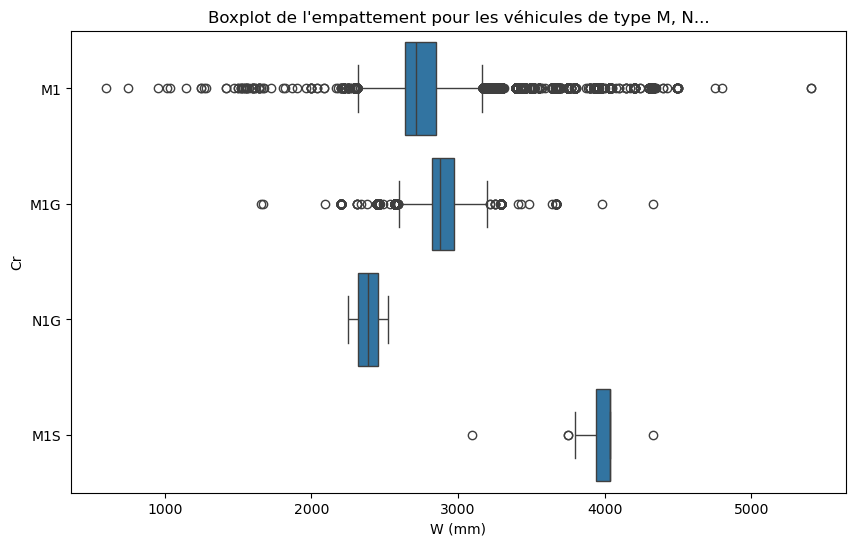

In [65]:
# Regardons un boxplot de distance entre essieux selon les types de véhicules
import seaborn as sns
import matplotlib.pyplot as plt


# Créer le boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_cleaned['W (mm)'], y=df_cleaned['Cr'])
plt.title("Boxplot de l'empattement pour les véhicules de type M, N...")
plt.xlabel('W (mm)')
plt.show()

Entre 1.5 et 4.5m, les valeurs sont plausibles.  
On va s'intéresser aux plus petites et plus grandes valeurs, qui sont en dehors de ce range.  

In [67]:
def show_extreme_W(side, nb):
    # Sélectionner les nb extremes de W (mm)
    if side == 'high':
        extreme_values = df_cleaned.nlargest(nb, 'W (mm)')
    else:
        extreme_values = df_cleaned.nsmallest(nb, 'W (mm)')
    
    # Créer un DataFrame combiné avec les colonnes souhaitées de df_cleaned et df
    combined_df = extreme_values[['W (mm)', 'm (kg)', 'At1 (mm)', 'At2 (mm)']].join(df[['Cn', 'Mk']], on=extreme_values.index, how='left')
    
    # Afficher le DataFrame combiné
    display(combined_df)


In [68]:
show_extreme_W("low",3)


,key_0,W (mm),m (kg),At1 (mm),At2 (mm),Cn,Mk
998124,998124,600.0,1451.0,1565.0,1577.0,KONA,HYUNDAI
1012332,1012332,750.0,2944.0,1735.0,1735.0,R560 4X4,RANDGER
329905,329905,954.0,2975.0,1752.0,1980.0,KRONOS 298 TL,ROLLER TEAM


75 cm pour un van de 6m de long ! Les gens qui ont saisi W pour le Randger 4x4 ont omis le '3' devant leur valeur wheel base  
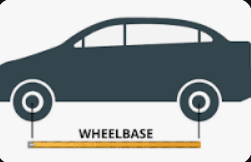  
en réalité il y a 3750 mm  
https://www.randger.com/wp-content/uploads/2025/01/RGD_R560-4x4_A4-Serie-speciale_EN_17-01-2025.pdf  
  
De même le Kronos 298 TL fait 7m de long, on va corriger 3954 mm car visuellement ça semble autour des 4m  
  
Et la Hyundai Kona a un wheel base de ~2600 mm

In [70]:
def replace_values(dfparam, replace_dict):
    """
    Remplace les valeurs dans la colonne 'W (mm)' du DataFrame selon le dictionnaire fourni.
    
    Input:
    dfparam (pd.DataFrame): Le DataFrame à traiter.
    replace_dict (dict): Le dictionnaire contenant les valeurs à remplacer.
    
    Output:
    pd.DataFrame: Le DataFrame avec les valeurs remplacées dans la colonne 'W (mm)'.
    """
    if 'W (mm)' in replace_dict:
        dfparam['W (mm)'] = dfparam['W (mm)'].replace(replace_dict['W (mm)'])
    return dfparam

In [71]:
replace_dict = {
    'W (mm)': {
        750: 3750,   # (camping car)
        954: 3954,   # Kronos 298 TL
        600: 2600    # Hyundai Kona
    }
}

replace_values(df_cleaned, replace_dict)

,Cn,Ft,Cr,m (kg),Ewltp (g/km),W (mm),At1 (mm),At2 (mm),Fm,ec (cm3),...,Electric range (km),Ft_new,IT28,IT29,IT32,IT33,IT35,IT37,IT38,IT39
2,MITSUBISHI ECLIPSE CROSS,petrol/electric,M1,1975.0,46.0,2670.0,1540.0,1540.0,P,2360.0,...,45.0,NaN,0,0,0,0,0,0,0,0
4,TOYOTA AYGO X,petrol/electric,M1,1020.0,108.0,2430.0,1540.0,1520.0,M,998.0,...,NaN,petrol/electric,0,0,0,0,0,0,0,0
5,PANDA,petrol,M1,1067.0,112.0,2300.0,1409.0,1407.0,H,999.0,...,NaN,NaN,0,0,0,1,0,0,0,0
8,SPORTAGE,petrol/electric,M1,1905.0,25.0,2680.0,1615.0,1622.0,P,1598.0,...,70.0,NaN,0,0,0,0,0,0,0,0
9,SPORTAGE,petrol/electric,M1,1905.0,25.0,2680.0,1615.0,1622.0,P,1598.0,...,70.0,NaN,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1533688,GLA 250 4MATIC,petrol,M1,1600.0,182.0,2729.0,1627.0,1619.0,M,1991.0,...,NaN,NaN,0,1,0,0,0,0,0,0
1533689,AMG GT 43 4MATIC+,petrol,M1,2040.0,221.0,2951.0,1675.0,1670.0,H,2999.0,...,NaN,NaN,0,0,0,0,0,0,0,0
1533690,KUGA,petrol,M1,1773.0,132.0,2710.0,1596.0,1580.0,H,2488.0,...,NaN,NaN,0,0,0,0,0,0,0,0
1533691,X5 xDrive45e,petrol/electric,M1G,2510.0,30.0,2975.0,1678.0,1698.0,P,2998.0,...,84.0,NaN,0,0,0,0,0,0,0,0


In [72]:
show_extreme_W("low",12)

,key_0,W (mm),m (kg),At1 (mm),At2 (mm),Cn,Mk
1136880,1136880,1013.0,1939.0,1518.0,1506.0,MUSTANG,FORD
1182626,1182626,1035.0,3074.0,1810.0,1980.0,MATRIX 650 SC,ADRIA
1136918,1136918,1145.0,1705.0,1552.0,1539.0,S4,AUDI
293228,293228,1248.0,1259.0,1472.0,1464.0,CORSA E,OPEL
884475,884475,1248.0,1259.0,1472.0,1464.0,CORSA E,OPEL
219341,219341,1270.0,1345.0,1542.0,1542.0,TIPO,FIAT
2189,2189,1278.0,1280.0,1520.0,1520.0,SX4,SUZUKI
489127,489127,1415.0,1050.0,1411.0,1411.0,500,FIAT
773912,773912,1420.0,1420.0,1533.0,1503.0,GOLF,VOLKSWAGEN
7504,7504,1470.0,1240.0,1535.0,1505.0,VITARA,SUZUKI


In [73]:
import pandas as pd


# Dictionnaire de remplacement avec valeurs trouvées en réel
replace_dict = {
    'W (mm)': {
        1013: 2719,  # Ford Mustang 2719 mm
        1035: 4035,  # MATRIX 650 SC ADRIA 4038 mm
        1145: 2825,  # S4 AUDI 2825 mm
        1248: 2538,  # Corsa E, ils ont saisi la moitié ?
        1270: 2630,  # Fiat Tipo
        1278: 2500,  # Suzuki SX4 ils ont mis ~la masse
        1415: 2320,  # ? Fiat 500
        1420: 2625,  # ? VW Golf ils ont saisi la masse
        1470: 2500,  # Suzuki Vitara
        1500: 2870,  # Mazda CX-60
        1500: 2849   # Ford S-max
    }
}

# Appeler la fonction pour remplacer les valeurs
#df2 = replace_values(df2, replace_dict)
replace_values(df_cleaned, replace_dict)


,Cn,Ft,Cr,m (kg),Ewltp (g/km),W (mm),At1 (mm),At2 (mm),Fm,ec (cm3),...,Electric range (km),Ft_new,IT28,IT29,IT32,IT33,IT35,IT37,IT38,IT39
2,MITSUBISHI ECLIPSE CROSS,petrol/electric,M1,1975.0,46.0,2670.0,1540.0,1540.0,P,2360.0,...,45.0,NaN,0,0,0,0,0,0,0,0
4,TOYOTA AYGO X,petrol/electric,M1,1020.0,108.0,2430.0,1540.0,1520.0,M,998.0,...,NaN,petrol/electric,0,0,0,0,0,0,0,0
5,PANDA,petrol,M1,1067.0,112.0,2300.0,1409.0,1407.0,H,999.0,...,NaN,NaN,0,0,0,1,0,0,0,0
8,SPORTAGE,petrol/electric,M1,1905.0,25.0,2680.0,1615.0,1622.0,P,1598.0,...,70.0,NaN,0,0,0,0,0,0,0,0
9,SPORTAGE,petrol/electric,M1,1905.0,25.0,2680.0,1615.0,1622.0,P,1598.0,...,70.0,NaN,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1533688,GLA 250 4MATIC,petrol,M1,1600.0,182.0,2729.0,1627.0,1619.0,M,1991.0,...,NaN,NaN,0,1,0,0,0,0,0,0
1533689,AMG GT 43 4MATIC+,petrol,M1,2040.0,221.0,2951.0,1675.0,1670.0,H,2999.0,...,NaN,NaN,0,0,0,0,0,0,0,0
1533690,KUGA,petrol,M1,1773.0,132.0,2710.0,1596.0,1580.0,H,2488.0,...,NaN,NaN,0,0,0,0,0,0,0,0
1533691,X5 xDrive45e,petrol/electric,M1G,2510.0,30.0,2975.0,1678.0,1698.0,P,2998.0,...,84.0,NaN,0,0,0,0,0,0,0,0


In [74]:
show_extreme_W("low",40)

,key_0,W (mm),m (kg),At1 (mm),At2 (mm),Cn,Mk
34196,34196,1518.0,1280.0,1562.0,1562.0,PUMA,FORD
14383,14383,1519.0,1359.0,1518.0,1518.0,ECOSPORT,FORD
1253582,1253582,1519.0,1359.0,1518.0,1518.0,ECOSPORT,FORD
41,41,1535.0,1240.0,1520.0,1520.0,VITARA,SUZUKI
1940,1940,1535.0,1385.0,1520.0,1520.0,SX4,SUZUKI
8607,8607,1550.0,1280.0,1655.0,1655.0,2008,PEUGEOT
33779,33779,1550.0,1280.0,1655.0,1655.0,2008,PEUGEOT
293456,293456,1552.0,1395.0,1552.0,1552.0,RENEGADE,JEEP
24547,24547,1559.0,1281.0,1559.0,1567.0,I30,HYUNDAI
155207,155207,1560.0,1322.0,1560.0,1560.0,C4,CITROEN


C'est à partir de la smart fortwo et du Secma Fun 1600 qu'un nombre exact apparait.  
On va mettre tous les <1867 restants à 2500 arbitrairement.  

In [76]:
df_cleaned.loc[df_cleaned["W (mm)"] < 1867, "W (mm)"] = 2500

In [77]:
show_extreme_W("low",40)

,key_0,W (mm),m (kg),At1 (mm),At2 (mm),Cn,Mk
1127710,1127710,1867.0,750.0,1450.0,1455.0,FORTWO,SMART
1125633,1125633,1900.0,730.0,1350.0,1350.0,ACTY,HONDA
1275862,1275862,1964.0,2046.0,1593.0,1593.0,S60,VOLVO
53890,53890,2000.0,668.0,1389.0,1423.0,FUN 1600 BUGGY,SECMA
89561,89561,2000.0,658.0,1412.0,1444.0,FUN 1600,SECMA
294682,294682,2000.0,658.0,1412.0,1444.0,FUN 1600,SECMA
294683,294683,2000.0,668.0,1389.0,1423.0,FUN 1600 BUGGY,SECMA
582194,582194,2000.0,658.0,1389.0,1444.0,FUN 1600,SECMA
176335,176335,2035.0,2720.0,1810.0,1790.0,CVE 601,CAPRON
1127148,1127148,2035.0,2880.0,1810.0,1980.0,TREND T 7057 DBM,DETHLEFFS


Encore des abérrations sur des campers  
Ils sont repérables à leur masse.  
On peut vérifier avec un scatterplot.


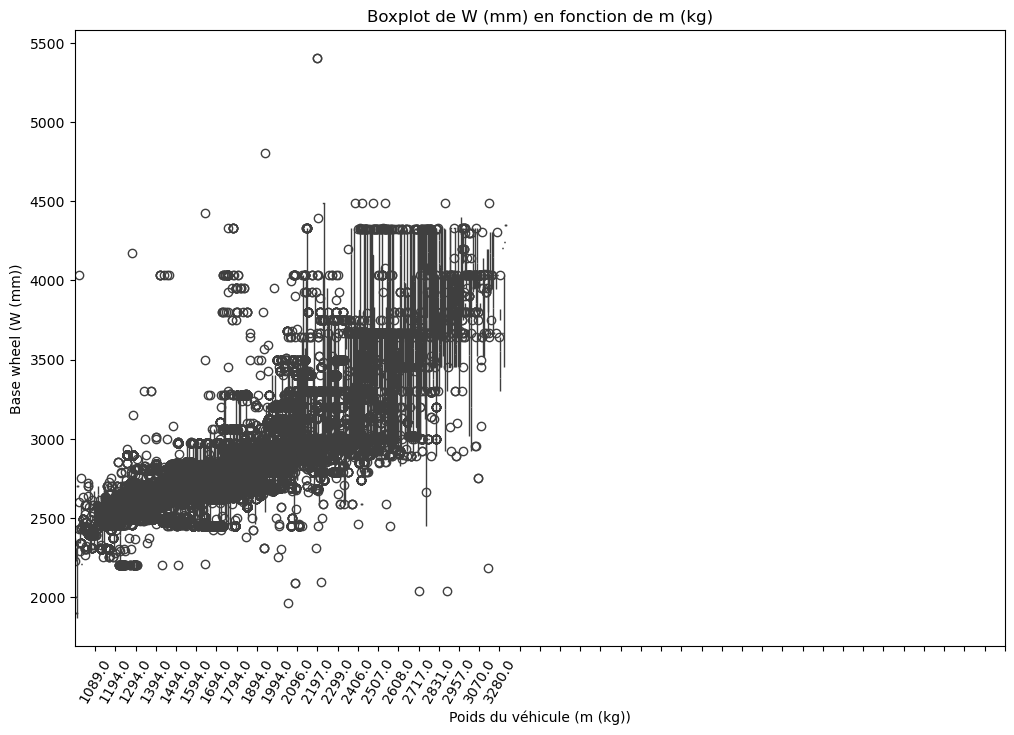

In [79]:
# Créer un boxplot de W (mm) en fonction de m (kg)
plt.figure(figsize=(12, 8))
sns.boxplot(x='m (kg)', y='W (mm)', data=df_cleaned)

# Ajouter un titre et configurer les labels
plt.title('Boxplot de W (mm) en fonction de m (kg)')
plt.xlabel('Poids du véhicule (m (kg))')
plt.ylabel('Base wheel (W (mm))')

# Configurer les graduations de l'axe des x tous les 100 kg
xticks = np.arange(100, df_cleaned['m (kg)'].max() + 100, 100)
plt.xticks(ticks=xticks, rotation=60)

# Afficher le graphique
plt.show()


il en reste peu qui sont louches, ce sont celles avec W<2200 avec une masse > 1900 kg

In [81]:
# Ajuster W (mm) pour les lignes ayant m (kg) > 1900
df_cleaned.loc[(df_cleaned['W (mm)'] < 2250) & (df_cleaned['m (kg)'] > 1900), 'W (mm)'] = 3000

In [82]:
# Sélectionner le point en haut à gauche 
smallest_mass = df_cleaned[(df_cleaned['W (mm)']>3000) & (df_cleaned['m (kg)']<1089)]

# Créer un DataFrame combiné avec les colonnes souhaitées de df_cleaned et df
combined_df = smallest_mass[['W (mm)', 'm (kg)']].join(df[['Cn', 'Mk']], on=smallest_mass.index, how='left')

# Afficher le DataFrame combiné
print(combined_df)

           key_0  W (mm)  m (kg)     Cn    Mk
1005943  1005943  4035.0   915.0  V600S  FIAT


In [83]:
# Fiat V600S est un camping car, c'est la masse qui est fausse. On la remplace par 3500
df_cleaned.loc[(df_cleaned['W (mm)'] == 4035) & (df_cleaned['m (kg)'] == 915), 'm (kg)'] = 3500

On a terminé avec l'empattement extreme bas, on regarde l'empattement extreme haut.  


In [85]:
show_extreme_W("high",30)

,key_0,W (mm),m (kg),At1 (mm),At2 (mm),Cn,Mk
135388,135388,5405.0,2195.0,1640.0,1640.0,MUSSO GRAND,SSANG YONG
989464,989464,5405.0,2195.0,1640.0,1640.0,MUSSO GRAND,SSANG YONG
1314358,1314358,4803.0,1933.0,1606.0,1606.0,S-MAX,FORD
1137766,1137766,4750.0,NaN,1723.0,1661.0,FLAIR 880LE,NIESMANN BISCHOFF
1103254,1103254,4500.0,3480.0,1759.0,1770.0,B790ML,HYMER
1129234,1129234,4500.0,3480.0,1759.0,1770.0,RQ7F6KA1FA2I24I790,HYMER
1176731,1176731,4500.0,3480.0,1759.0,1770.0,B780ML,HYMER
1182639,1182639,4500.0,3430.0,1810.0,1980.0,I 7150-2,FIAT
706791,706791,4490.0,3487.0,1770.0,1766.0,CRAFTER,VOLKSWAGEN
773420,773420,4490.0,2874.0,1770.0,1788.0,TGE,MAN


Juste quelques véhicules légers, les autres sont des transporters ou camping-cars

In [87]:
# Dictionnaire de remplacement avec valeurs trouvées en réel
replace_dict = {
    'W (mm)': {
        5405: 3210,  # musso grand
        4803: 2849,  # Ford S-Max
        4425: 2702,  # Volvo XC-40
        4395: 2681,  # Jaguar e-pace
    }
}

# Appeler la fonction pour remplacer les valeurs
#df2 = replace_values(df2, replace_dict)
replace_values(df_cleaned, replace_dict)

,Cn,Ft,Cr,m (kg),Ewltp (g/km),W (mm),At1 (mm),At2 (mm),Fm,ec (cm3),...,Electric range (km),Ft_new,IT28,IT29,IT32,IT33,IT35,IT37,IT38,IT39
2,MITSUBISHI ECLIPSE CROSS,petrol/electric,M1,1975.0,46.0,2670.0,1540.0,1540.0,P,2360.0,...,45.0,NaN,0,0,0,0,0,0,0,0
4,TOYOTA AYGO X,petrol/electric,M1,1020.0,108.0,2430.0,1540.0,1520.0,M,998.0,...,NaN,petrol/electric,0,0,0,0,0,0,0,0
5,PANDA,petrol,M1,1067.0,112.0,2300.0,1409.0,1407.0,H,999.0,...,NaN,NaN,0,0,0,1,0,0,0,0
8,SPORTAGE,petrol/electric,M1,1905.0,25.0,2680.0,1615.0,1622.0,P,1598.0,...,70.0,NaN,0,0,0,0,0,0,0,0
9,SPORTAGE,petrol/electric,M1,1905.0,25.0,2680.0,1615.0,1622.0,P,1598.0,...,70.0,NaN,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1533688,GLA 250 4MATIC,petrol,M1,1600.0,182.0,2729.0,1627.0,1619.0,M,1991.0,...,NaN,NaN,0,1,0,0,0,0,0,0
1533689,AMG GT 43 4MATIC+,petrol,M1,2040.0,221.0,2951.0,1675.0,1670.0,H,2999.0,...,NaN,NaN,0,0,0,0,0,0,0,0
1533690,KUGA,petrol,M1,1773.0,132.0,2710.0,1596.0,1580.0,H,2488.0,...,NaN,NaN,0,0,0,0,0,0,0,0
1533691,X5 xDrive45e,petrol/electric,M1G,2510.0,30.0,2975.0,1678.0,1698.0,P,2998.0,...,84.0,NaN,0,0,0,0,0,0,0,0



On a terminé les empattements  
  
  ***  
  
On s'intéresse maintenant à la distance entre roues AT1  

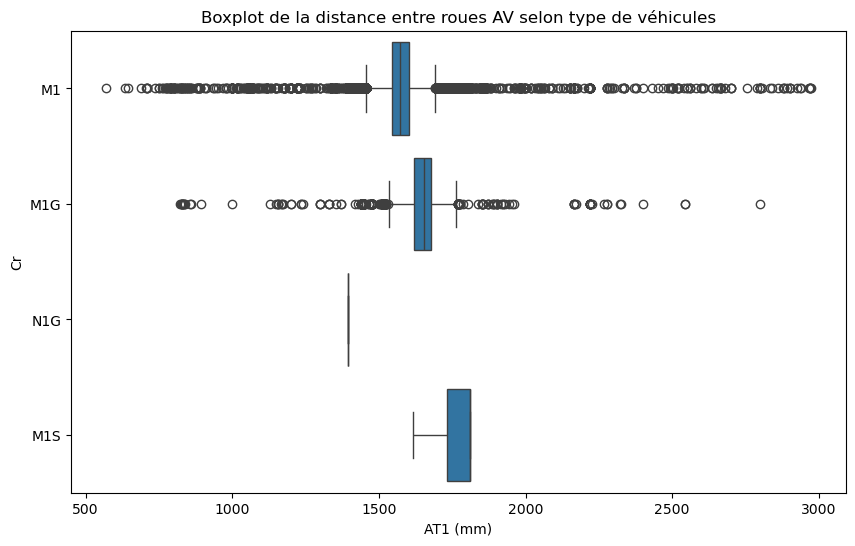

In [89]:
# Regardons un boxplot de At1 différencié par type d'utilisation de véhicule
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
sns.boxplot(x=df_cleaned['At1 (mm)'], y=df_cleaned['Cr'])
plt.title('Boxplot de la distance entre roues AV selon type de véhicules')
plt.xlabel('AT1 (mm)')
plt.show()

comme souvent, on doit regarder les quelques extrêmes  

In [91]:
def show_extreme_At(side, nb):
    # Sélectionner les n valeurs extremes
    if ( side == "low"):
        smallest_values = df_cleaned.nsmallest(nb, 'At1 (mm)')
    else:
        smallest_values = df_cleaned.nlargest(nb, 'At1 (mm)')
    # Créer un DataFrame combiné avec les colonnes souhaitées de df_cleaned et df
    combined_df = smallest_values[['W (mm)', 'm (kg)', 'At1 (mm)', 'At2 (mm)']].join(df[['Cn', 'Mk']], on=smallest_values.index, how='left')
    
    # Afficher le DataFrame combiné
    pd.set_option('display.max_rows', 200)
    display(combined_df)

In [92]:
show_extreme_At("low", nb=200)

,key_0,W (mm),m (kg),At1 (mm),At2 (mm),Cn,Mk
27259,27259,2636.0,1600.0,570.0,570.0,TONALE,ALFA ROMEO
155348,155348,2310.0,1113.0,635.0,645.0,MX-5,MAZDA
1000625,1000625,2310.0,1147.0,645.0,660.0,MX5,MAZDA
45,45,2500.0,1240.0,688.0,688.0,VITARA,SUZUKI
24174,24174,2300.0,1074.0,705.0,705.0,500,FIAT
8726,8726,2300.0,1064.0,710.0,710.0,500,FIAT
11190,11190,2300.0,1064.0,710.0,710.0,500,FIAT
14914,14914,2300.0,1064.0,710.0,710.0,500,FIAT
853,853,2493.0,1159.0,737.0,737.0,FIESTA,FORD
70,70,2450.0,965.0,750.0,750.0,SWIFT,SUZUKI


L'Alfa Romeo Tonale a environ 1570 mm entre roues. Ils ont probablement oublié le 1 initial.  
Pour la Peugeot 308, ils ont saisi ~ la moitié (777 au lieu de 1559).  
Pour les autres, c'es pas compréhensible, il y a des valeurs pas plausibles.  
On pourrait placer 1600 pour tous ceux qui ont saisi < 1500  
  
Une analyse rapide montre que la qualité des saisies sur AT2 (mm) est exactement pareil => on applique la même chose.

In [94]:
df_cleaned['At1 (mm)'] = df_cleaned['At1 (mm)'].apply(lambda x: 1600 if x < 1500 else x)
df_cleaned['At2 (mm)'] = df_cleaned['At2 (mm)'].apply(lambda x: 1600 if x < 1500 else x)

In [95]:
show_extreme_At("high",50) 

,key_0,W (mm),m (kg),At1 (mm),At2 (mm),Cn,Mk
131,131,2500.0,1320.0,2972.0,2972.0,VITARA,SUZUKI
1858,1858,2557.0,1295.0,2970.0,2970.0,MOKKA,OPEL
15071,15071,2557.0,1295.0,2970.0,2970.0,MOKKA,OPEL
30562,30562,2557.0,1295.0,2970.0,2970.0,MOKKA,OPEL
20656,20656,2655.0,1530.0,2967.0,2967.0,CX-30,MAZDA
7585,7585,2670.0,1353.0,2940.0,2940.0,C4,CITROEN
42048,42048,2300.0,1064.0,2935.0,2935.0,500,FIAT
86907,86907,2605.0,1345.0,2925.0,2925.0,2008,PEUGEOT
94102,94102,2850.0,1696.0,2902.0,2902.0,MONDEO HYBRID,FORD
465702,465702,2604.0,1280.0,2901.0,2901.0,C3 AIRCROSS,CITROEN


La législation fixe la largeur max d'un véhicule M1/N1 à 2550mmm. On peut donc difficilement avoir une voie (At) > 2100mmm

Suzuki VITARA fait 1775mm de large, At1 et At2 vus dans le reste de la base df sont de 1535mm
Opel MOKKA fait 1791mm de large, At1 et At2 vus dans le reste de la base df sont de 1550
mazda cx-30 trouvé à 1565mm, internet
Citroen C4 1520, internet
Fiat 500 1470, base
peugeot 2008 : 1480, internet
MONDEO HYBRID	FORD : 1597, base

On comprend qu'au-dessus de 2m ce sera principalement des erreurs de saisie  
On corrige donc pour mettre 1550 (on corrige ainsi jusque 1198 pour inclure une Hyundai et une mazda concernés)

en dessous de 1998 on commence à avoir des dimensions réelles car c'est du Ford transit. Bien entendu on aura encore des erreurs mais on a corrigé les plus grosses. 



In [97]:
df_cleaned['At1 (mm)'] = df_cleaned['At1 (mm)'].apply(lambda x: 1550 if x > 1998 else x)
df_cleaned['At2 (mm)'] = df_cleaned['At2 (mm)'].apply(lambda x: 1550 if x > 1998 else x)


In [98]:
# Sauvegarde des données après ce 1er feature engineering
#df_cleaned.to_csv('data/eea_europa/data2022_feature_engineered07.csv', index=False)

In [99]:
df_cleaned.head()

,Cn,Ft,Cr,m (kg),Ewltp (g/km),W (mm),At1 (mm),At2 (mm),Fm,ec (cm3),...,Electric range (km),Ft_new,IT28,IT29,IT32,IT33,IT35,IT37,IT38,IT39
2,MITSUBISHI ECLIPSE CROSS,petrol/electric,M1,1975.0,46.0,2670.0,1540.0,1540.0,P,2360.0,...,45.0,NaN,0,0,0,0,0,0,0,0
4,TOYOTA AYGO X,petrol/electric,M1,1020.0,108.0,2430.0,1540.0,1520.0,M,998.0,...,NaN,petrol/electric,0,0,0,0,0,0,0,0
5,PANDA,petrol,M1,1067.0,112.0,2300.0,1600.0,1600.0,H,999.0,...,NaN,NaN,0,0,0,1,0,0,0,0
8,SPORTAGE,petrol/electric,M1,1905.0,25.0,2680.0,1615.0,1622.0,P,1598.0,...,70.0,NaN,0,0,0,0,0,0,0,0
9,SPORTAGE,petrol/electric,M1,1905.0,25.0,2680.0,1615.0,1622.0,P,1598.0,...,70.0,NaN,0,0,0,0,0,0,0,0


In [100]:
# Réinitialiser l'index pour remettre l'index actuel (numérotation des lignes) comme colonne
df_cleaned.reset_index(inplace=True)

# Vérifie les colonnes après réinitialisation de l'index
print(df_cleaned.columns)  # Cela devrait afficher 'Unnamed: 0' si c'est le cas

# Remplacer "Unnamed: 0" par le nom de la colonne qui contient la numérotation
df_cleaned.set_index("index", inplace=True)

# Vérifier le résultat
print(df_cleaned.head())  # Vérifie que l'index a bien été défini

Index(['index', 'Cn', 'Ft', 'Cr', 'm (kg)', 'Ewltp (g/km)', 'W (mm)',
       'At1 (mm)', 'At2 (mm)', 'Fm', 'ec (cm3)', 'ep (KW)', 'z (Wh/km)', 'IT',
       'Erwltp (g/km)', 'Electric range (km)', 'Ft_new', 'IT28', 'IT29',
       'IT32', 'IT33', 'IT35', 'IT37', 'IT38', 'IT39'],
      dtype='object')
                             Cn               Ft  Cr  m (kg)  Ewltp (g/km)  \
index                                                                        
2      MITSUBISHI ECLIPSE CROSS  petrol/electric  M1  1975.0          46.0   
4                 TOYOTA AYGO X  petrol/electric  M1  1020.0         108.0   
5                         PANDA           petrol  M1  1067.0         112.0   
8                      SPORTAGE  petrol/electric  M1  1905.0          25.0   
9                      SPORTAGE  petrol/electric  M1  1905.0          25.0   

       W (mm)  At1 (mm)  At2 (mm) Fm  ec (cm3)  ...  Electric range (km)  \
index                                           ...                        
2

In [101]:
#On s'intéresse maintenant à la puissance 'ep (KW)'
df_cleaned['ep (KW)'].describe()

count    1.339441e+06
mean     1.366628e+02
std      6.218924e+01
min      7.000000e+00
25%      1.000000e+02
50%      1.120000e+02
75%      1.500000e+02
max      1.177000e+03
Name: ep (KW), dtype: float64

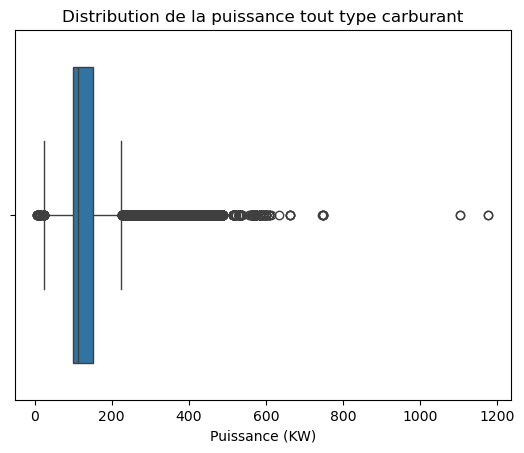

In [102]:
#on regarde la distribution des données
sns.boxplot(x=df_cleaned['ep (KW)'])
plt.title('Distribution de la puissance tout type carburant')
plt.xlabel('Puissance (KW)')
plt.show()

In [103]:
# Détection des outliers
Q1 = df_cleaned['ep (KW)'].quantile(0.25)  # Premier quartile
Q3 = df_cleaned['ep (KW)'].quantile(0.75)  # Troisième quartile
IQR = Q3 - Q1  # Étendue interquartile

# Limites pour détecter les outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrer les extrêmes
outliers = df_cleaned[(df_cleaned['ep (KW)'] < lower_bound) | (df_cleaned['ep (KW)'] > upper_bound)]

In [104]:
print("Il y selon cette méthode:", len(outliers), "outliers")

Il y selon cette méthode: 120436 outliers


In [105]:
df_cleaned['Ft'].value_counts()

Ft
petrol             618504
diesel             532632
petrol/electric    174785
diesel/electric     13681
Name: count, dtype: int64

In [106]:
#je regarde l'impact du type de carburant sur les données de puissance
fuel_stats = df_cleaned.groupby('Ft')['ep (KW)'].describe()
print(fuel_stats)

                    count        mean        std    min    25%    50%    75%  \
Ft                                                                             
diesel           532588.0  134.266279  42.847050    7.0  110.0  120.0  147.0   
diesel/electric   13681.0  143.016812   1.151345  143.0  143.0  143.0  143.0   
petrol           618391.0  136.453880  77.148249    8.0   92.0  110.0  145.0   
petrol/electric  174781.0  144.206870  53.930941   28.0  110.0  132.0  186.0   

                    max  
Ft                       
diesel            530.0  
diesel/electric   250.0  
petrol           1177.0  
petrol/electric   574.0  


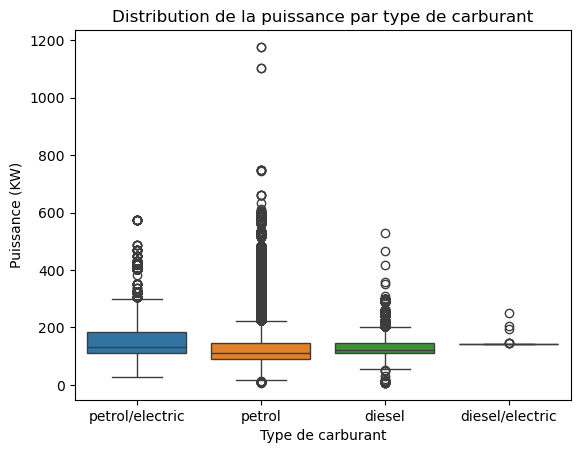

In [107]:
#Visualiser les distributions par type de carburant
sns.boxplot(data=df_cleaned, x='Ft', y='ep (KW)', hue = 'Ft')
plt.title('Distribution de la puissance par type de carburant')
plt.xlabel('Type de carburant')
plt.ylabel('Puissance (KW)')
plt.show()

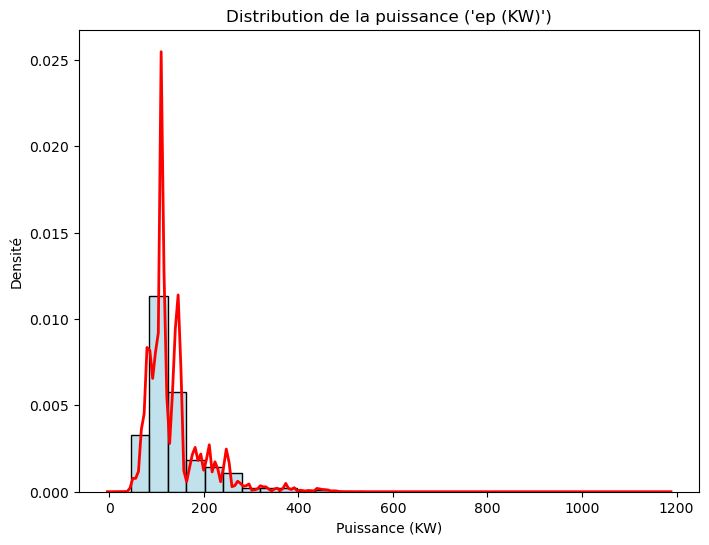

In [108]:
plt.figure(figsize=(8,6))

# Histogramme sans courbe KDE
sns.histplot(df_cleaned['ep (KW)'], bins=30, color='lightblue', edgecolor='black', stat="density")

# Ajouter manuellement la courbe KDE par-dessus
sns.kdeplot(df_cleaned['ep (KW)'], color='red', linewidth=2)

plt.title("Distribution de la puissance ('ep (KW)')")
plt.xlabel("Puissance (KW)")
plt.ylabel("Densité")
plt.show()

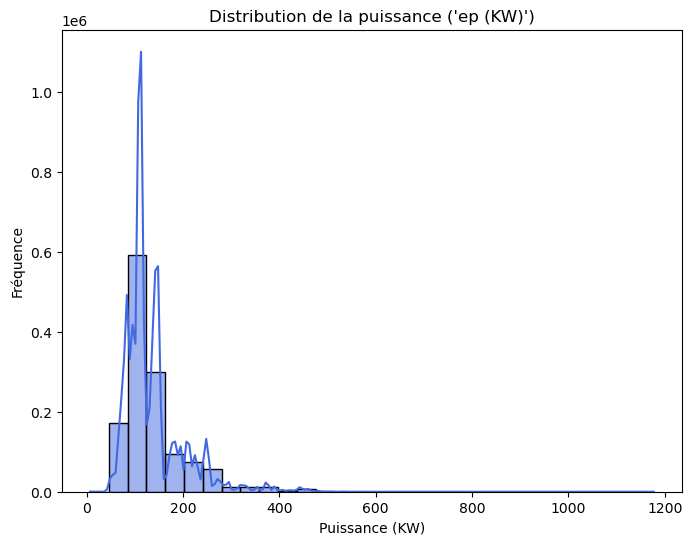

In [109]:
plt.figure(figsize=(8,6))

# Histogramme avec courbe de densité
sns.histplot(df_cleaned['ep (KW)'], bins=30, kde=True, color='royalblue', edgecolor='black')

plt.title("Distribution de la puissance ('ep (KW)')")
plt.xlabel("Puissance (KW)")
plt.ylabel("Fréquence")
plt.show()

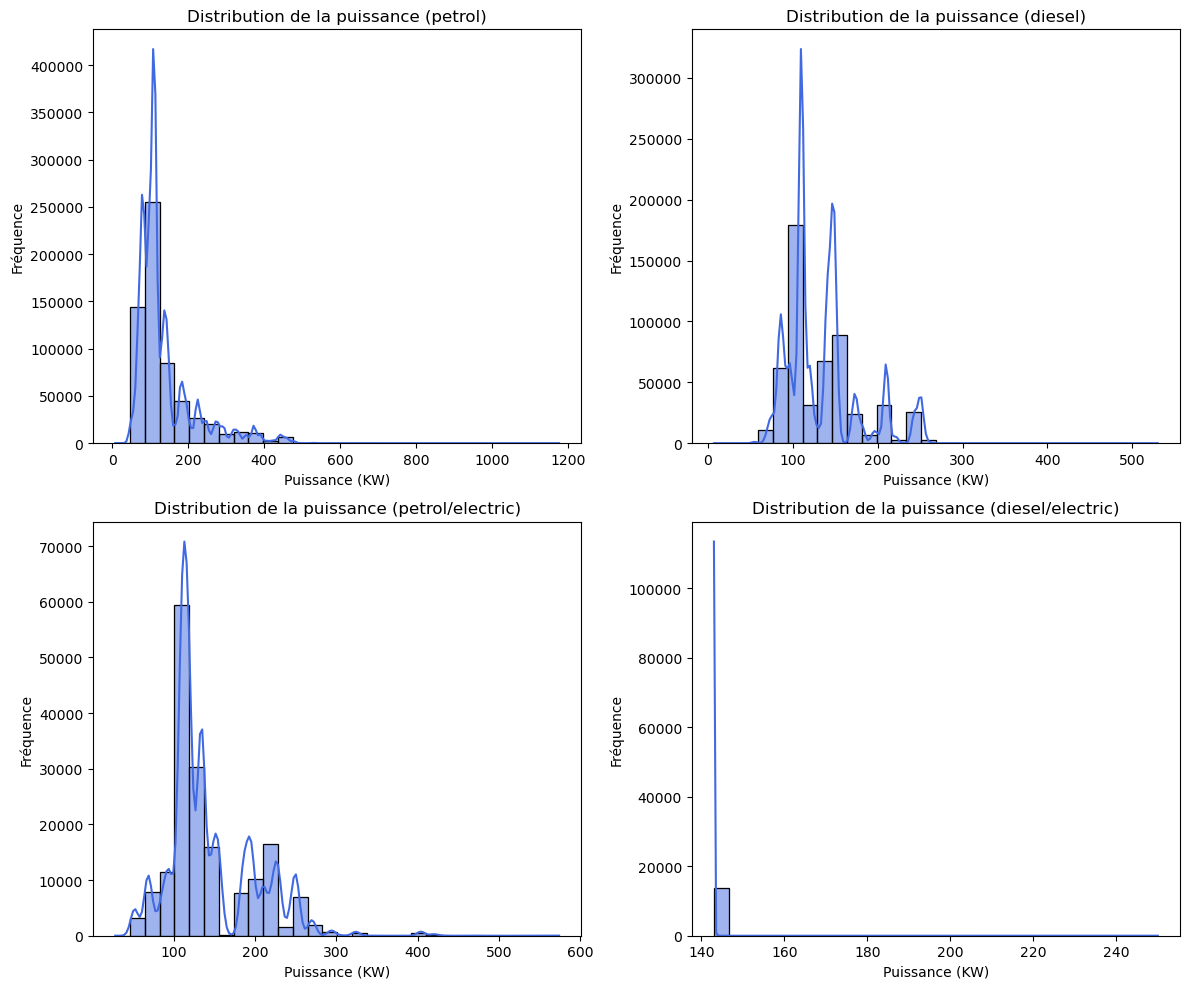

In [110]:
# Définir les types de carburants
carburants = ['petrol', 'diesel', 'petrol/electric', 'diesel/electric']

# Créer la figure et les sous-graphiques (2 lignes, 2 colonnes)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Boucle sur chaque carburant et tracer un histogramme + KDE
for i, fuel in enumerate(carburants):
    ax = axes[i//2, i%2]  # Position dans la grille (2x2)
    
    # Filtrer les données
    data_filtree = df_cleaned[df_cleaned['Ft'] == fuel]
    
    # Tracer l'histogramme avec la courbe KDE
    sns.histplot(data_filtree['ep (KW)'], bins=30, kde=True, color='royalblue', edgecolor='black', ax=ax)
    
    # Titres et labels
    ax.set_title(f"Distribution de la puissance ({fuel})")
    ax.set_xlabel("Puissance (KW)")
    ax.set_ylabel("Fréquence")

# Ajuster l'affichage pour éviter les chevauchements
plt.tight_layout()
plt.show()

                Ft  ep (KW)
0           diesel       44
1  diesel/electric        0
2           petrol      113
3  petrol/electric        4


C:\Users\abcd3\AppData\Local\Temp\ipykernel_29620\2851132067.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=nan_counts, x='Type de carburant', y='Nombre de NaN', palette='coolwarm')


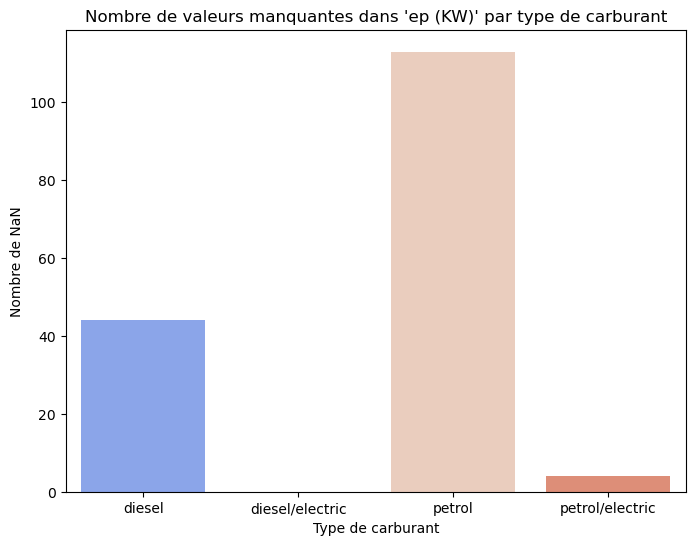

In [111]:
# Compter les NaN dans 'ep (KW)' par type de carburant
nan_counts = df_cleaned.groupby('Ft')['ep (KW)'].apply(lambda x: x.isna().sum()).reset_index()
print(nan_counts)
nan_counts.columns = ['Type de carburant', 'Nombre de NaN']

# Afficher les valeurs manquantes sous forme de barplot
plt.figure(figsize=(8,6))
sns.barplot(data=nan_counts, x='Type de carburant', y='Nombre de NaN', palette='coolwarm')

plt.title("Nombre de valeurs manquantes dans 'ep (KW)' par type de carburant")
plt.xlabel("Type de carburant")
plt.ylabel("Nombre de NaN")
plt.show()

In [112]:
# Filtrer uniquement les carburants concernés
carburants = ['petrol', 'diesel', 'petrol/electric', 'diesel/electric']

# Supprimer les NaN dans 'ep (KW)' uniquement pour ces types de carburants
df_cleaned = df_cleaned.dropna(subset=['ep (KW)'])

# Vérifier si les NaN ont bien été supprimés
print(df_cleaned.isna().sum())  # Vérification

Cn                        8703
Ft                           0
Cr                          15
m (kg)                      11
Ewltp (g/km)               497
W (mm)                       0
At1 (mm)                     0
At2 (mm)                     0
Fm                           0
ec (cm3)                    25
ep (KW)                      0
z (Wh/km)              1161713
IT                      393975
Erwltp (g/km)           427996
Electric range (km)    1168177
Ft_new                 1332326
IT28                         0
IT29                         0
IT32                         0
IT33                         0
IT35                         0
IT37                         0
IT38                         0
IT39                         0
dtype: int64


In [113]:
#Recalculer les outliers par type de carburant
# Étape 1 : Définir une fonction pour calculer les bornes des outliers
def calculate_outlier_bounds(group):
    Q1 = group['ep (KW)'].quantile(0.25)  # Premier quartile
    Q3 = group['ep (KW)'].quantile(0.75)  # Troisième quartile
    IQR = Q3 - Q1  # Étendue interquartile
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Étape 2 : Identifier les outliers par type de carburant
def count_outliers(group):
    lower_bound, upper_bound = calculate_outlier_bounds(group)
    # Compter les valeurs hors des bornes
    outliers = group[(group['ep (KW)'] < lower_bound) | (group['ep (KW)'] > upper_bound)]
    total_count = len(group)  # Nombre total de valeurs dans le groupe
    outlier_count = len(outliers)  # Nombre d'outliers
    return pd.Series({
        'total_count': total_count,
        'outlier_count': outlier_count,
        'outlier_percentage': (outlier_count / total_count) * 100
    })

# Appliquer par groupe de type de carburant
outlier_stats = df_cleaned.groupby('Ft').apply(count_outliers)

# Résultat final
print(outlier_stats)

                 total_count  outlier_count  outlier_percentage
Ft                                                             
diesel              532588.0        60689.0           11.395112
diesel/electric      13681.0            7.0            0.051166
petrol              618391.0        76601.0           12.387147
petrol/electric     174781.0         1238.0            0.708315


C:\Users\abcd3\AppData\Local\Temp\ipykernel_29620\4122608951.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outlier_stats = df_cleaned.groupby('Ft').apply(count_outliers)


C:\Users\abcd3\AppData\Local\Temp\ipykernel_29620\701194098.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=outlier_stats.index, y=outlier_stats['outlier_percentage'],palette='coolwarm')


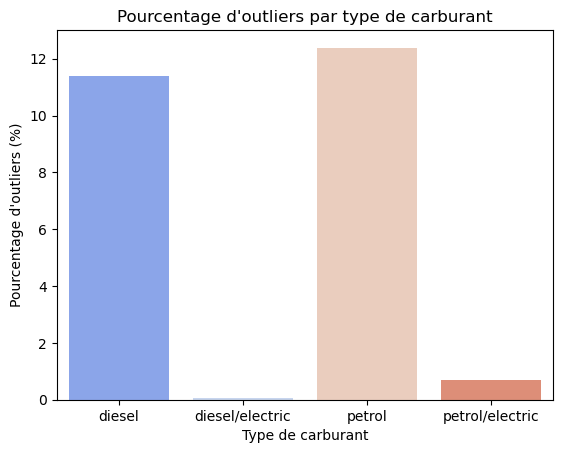

In [114]:
# Barplot pour les pourcentages
sns.barplot(x=outlier_stats.index, y=outlier_stats['outlier_percentage'],palette='coolwarm')
plt.title("Pourcentage d'outliers par type de carburant")
plt.xlabel("Type de carburant")
plt.ylabel("Pourcentage d'outliers (%)")
plt.show()

In [115]:
# Trier les données par ordre décroissant de 'ep (KW)'
top_20_max = df_cleaned.nlargest(20, 'ep (KW)')

# Afficher les 20 valeurs max
print(top_20_max[['ep (KW)', 'Ft']])

         ep (KW)      Ft
index                   
800717    1177.0  petrol
1048043   1177.0  petrol
199152    1103.0  petrol
1311591   1103.0  petrol
253805     747.0  petrol
373048     747.0  petrol
392800     747.0  petrol
1278807    747.0  petrol
1354758    747.0  petrol
1014113    746.0  petrol
331298     662.0  petrol
331302     662.0  petrol
694150     662.0  petrol
694158     662.0  petrol
1416344    635.0  petrol
319589     614.0  petrol
53778      607.0  petrol
54188      607.0  petrol
94543      607.0  petrol
107755     607.0  petrol


In [116]:
# Ajouter une colonne pour la puissance en chevaux (ch)
df_cleaned['ep (ch)'] = df_cleaned['ep (KW)'] * 1.36

# Afficher les 5 premières lignes pour vérifier
print(df_cleaned[['ep (KW)', 'ep (ch)']].head())

       ep (KW)  ep (ch)
index                  
2         72.0    97.92
4         53.0    72.08
5         52.0    70.72
8        132.0   179.52
9        132.0   179.52


C:\Users\abcd3\AppData\Local\Temp\ipykernel_29620\3214174217.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['ep (ch)'] = df_cleaned['ep (KW)'] * 1.36


In [117]:
# Trier les données par ordre décroissant de 'ep (ch)'
top_25_max = df_cleaned.nlargest(25, 'ep (ch)')

# Afficher les 25 valeurs max
print(top_25_max[['ep (ch)', 'Ft']])

         ep (ch)      Ft
index                   
800717   1600.72  petrol
1048043  1600.72  petrol
199152   1500.08  petrol
1311591  1500.08  petrol
253805   1015.92  petrol
373048   1015.92  petrol
392800   1015.92  petrol
1278807  1015.92  petrol
1354758  1015.92  petrol
1014113  1014.56  petrol
331298    900.32  petrol
331302    900.32  petrol
694150    900.32  petrol
694158    900.32  petrol
1416344   863.60  petrol
319589    835.04  petrol
53778     825.52  petrol
54188     825.52  petrol
94543     825.52  petrol
107755    825.52  petrol
409789    825.52  petrol
289240    816.00  petrol
520594    816.00  petrol
622415    816.00  petrol
1278562   816.00  petrol


        Ft    index  ep (KW)
0   diesel   101007     13.0
1   diesel   223405     10.0
2   diesel   716687     51.0
3   diesel   998433     12.0
4   diesel  1006304     14.0
5   diesel  1010354     14.0
6   diesel  1011524      7.0
7   diesel  1011872     10.0
8   diesel  1014092     11.0
9   diesel  1014205     10.0
10  diesel  1014215     14.0
11  diesel  1061732     49.0
12  diesel  1101247      7.0
13  diesel  1103189     30.0
14  diesel  1104319     13.0
15  diesel  1106219      7.0
16  diesel  1106258     13.0
17  diesel  1107711     50.0
18  diesel  1130333     13.0
19  diesel  1132260     14.0
20  diesel  1133190     10.0
21  diesel  1133874     19.0
22  diesel  1135713     14.0
23  diesel  1138955     14.0
24  diesel  1139455      7.0
25  diesel  1140787     14.0
26  diesel  1157092     13.0
27  diesel  1157446      7.0
28  diesel  1183324     13.0
29  diesel  1184301     13.0
30  petrol     6351     10.0
31  petrol     8246     10.0
32  petrol    10973     10.0
33  petrol    

C:\Users\abcd3\AppData\Local\Temp\ipykernel_29620\252472955.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=outliers_count, x=group_col, y="Nombre d'outliers bas", palette='coolwarm')


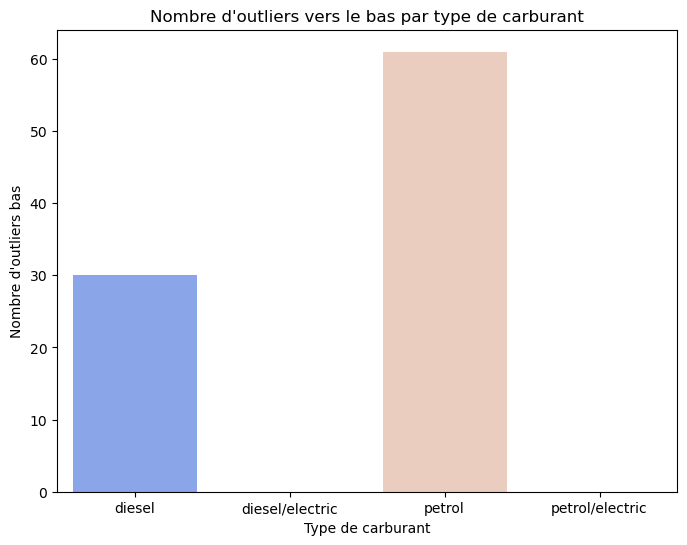

In [118]:
def detect_and_plot_outliers(df, group_col, value_col):
    def detect_outliers(group):
        Q1 = group.quantile(0.25)
        Q3 = group.quantile(0.75)
        IQR = Q3 - Q1
        seuil_bas = Q1 - 1.5 * IQR
        return group[group < seuil_bas]  # Retourne les valeurs aberrantes

    # Détection des outliers
    outliers = df.groupby(group_col)[value_col].apply(detect_outliers).reset_index()

    # Comptage des outliers bas par carburant, en gardant tous les groupes
    outliers_count = df.groupby(group_col)[value_col].apply(lambda x: (x < x.quantile(0.25) - 1.5 * (x.quantile(0.75) - x.quantile(0.25))).sum()).reset_index()
    outliers_count.columns = [group_col, "Nombre d'outliers bas"]

    # Affichage des résultats
    print(outliers)
    print(f"Total d'outliers détectés : {outliers_count['Nombre d\'outliers bas'].sum()}")

    # Création du barplot
    plt.figure(figsize=(8,6))
    sns.barplot(data=outliers_count, x=group_col, y="Nombre d'outliers bas", palette='coolwarm')
    plt.title("Nombre d'outliers vers le bas par type de carburant")
    plt.xlabel("Type de carburant")
    plt.ylabel("Nombre d'outliers bas")
    plt.show()

    return outliers, outliers_count  # Retour des résultats

# Utilisation de la fonction
outliers, outliers_count = detect_and_plot_outliers(df_cleaned, 'Ft', 'ep (KW)')


In [119]:
# Trier les données par 'ep (ch)' pour chaque type de carburant
top_25_max_per_fuel = df_cleaned.groupby('Ft').apply(lambda group: group.nlargest(25, 'ep (ch)'))
print(top_25_max_per_fuel[['ep (ch)', 'Ft']])

                         ep (ch)               Ft
Ft              index                            
diesel          1278467   720.80           diesel
                1193811   635.12           diesel
                1011122   565.76           diesel
                1130765   489.60           diesel
                779291    476.00           diesel
                942529    421.60           diesel
                65898     408.00           diesel
                76641     408.00           diesel
                130750    408.00           diesel
                180636    408.00           diesel
                288610    408.00           diesel
                370257    408.00           diesel
                423959    408.00           diesel
                469348    408.00           diesel
                469352    408.00           diesel
                469353    408.00           diesel
                469428    408.00           diesel
                736108    408.00           diesel


C:\Users\abcd3\AppData\Local\Temp\ipykernel_29620\489108095.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_25_max_per_fuel = df_cleaned.groupby('Ft').apply(lambda group: group.nlargest(25, 'ep (ch)'))


In [120]:
df_cleaned.reset_index(inplace=True)  # Remet l'index en colonne

In [121]:
print(df_cleaned.index.name)  # Affiche le nom de l'index actuel
print(df_cleaned.head())  # Vérifie la structure du DataFrame

None
   index                        Cn               Ft  Cr  m (kg)  Ewltp (g/km)  \
0      2  MITSUBISHI ECLIPSE CROSS  petrol/electric  M1  1975.0          46.0   
1      4             TOYOTA AYGO X  petrol/electric  M1  1020.0         108.0   
2      5                     PANDA           petrol  M1  1067.0         112.0   
3      8                  SPORTAGE  petrol/electric  M1  1905.0          25.0   
4      9                  SPORTAGE  petrol/electric  M1  1905.0          25.0   

   W (mm)  At1 (mm)  At2 (mm) Fm  ...           Ft_new  IT28  IT29 IT32  IT33  \
0  2670.0    1540.0    1540.0  P  ...              NaN     0     0    0     0   
1  2430.0    1540.0    1520.0  M  ...  petrol/electric     0     0    0     0   
2  2300.0    1600.0    1600.0  H  ...              NaN     0     0    0     1   
3  2680.0    1615.0    1622.0  P  ...              NaN     0     0    0     0   
4  2680.0    1615.0    1622.0  P  ...              NaN     0     0    0     0   

   IT35 IT37  IT38  I

In [122]:
print(df_cleaned.columns)

Index(['index', 'Cn', 'Ft', 'Cr', 'm (kg)', 'Ewltp (g/km)', 'W (mm)',
       'At1 (mm)', 'At2 (mm)', 'Fm', 'ec (cm3)', 'ep (KW)', 'z (Wh/km)', 'IT',
       'Erwltp (g/km)', 'Electric range (km)', 'Ft_new', 'IT28', 'IT29',
       'IT32', 'IT33', 'IT35', 'IT37', 'IT38', 'IT39', 'ep (ch)'],
      dtype='object')


In [123]:
# Sélectionner toutes les colonnes de type 'object' (chaînes de caractères)
object_columns = df_cleaned.select_dtypes(include='object')

# Créer un tableau pour afficher les modalités de chaque variable
modalites = {col: object_columns[col].unique() for col in object_columns.columns}

# Convertir en DataFrame pour avoir une présentation plus claire
modalites_df = pd.DataFrame({col: pd.Series(object_columns[col].unique()) for col in object_columns.columns})

# Afficher les résultats
print(modalites_df)

                            Cn               Ft   Cr   Fm        IT  \
0     MITSUBISHI ECLIPSE CROSS  petrol/electric   M1    P       NaN   
1                TOYOTA AYGO X           petrol  M1G    M     e3 33   
2                        PANDA           diesel  NaN    H     e6 37   
3                     SPORTAGE  diesel/electric  N1G  NaN     e1 29   
4                         HR-V              NaN  M1S  NaN  e4 32 37   
...                        ...              ...  ...  ...       ...   
5658                    V65 GE              NaN  NaN  NaN       NaN   
5659                  S-SERIES              NaN  NaN  NaN       NaN   
5660                    CAMP A              NaN  NaN  NaN       NaN   
5661               Toyota C-HR              NaN  NaN  NaN       NaN   
5662             RS3 Sportback              NaN  NaN  NaN       NaN   

               Ft_new  
0                 NaN  
1     petrol/electric  
2              petrol  
3                 NaN  
4                 NaN  
...

In [124]:
df_cleaned.head()

,index,Cn,Ft,Cr,m (kg),Ewltp (g/km),W (mm),At1 (mm),At2 (mm),Fm,...,Ft_new,IT28,IT29,IT32,IT33,IT35,IT37,IT38,IT39,ep (ch)
0,2,MITSUBISHI ECLIPSE CROSS,petrol/electric,M1,1975.0,46.0,2670.0,1540.0,1540.0,P,...,NaN,0,0,0,0,0,0,0,0,97.92
1,4,TOYOTA AYGO X,petrol/electric,M1,1020.0,108.0,2430.0,1540.0,1520.0,M,...,petrol/electric,0,0,0,0,0,0,0,0,72.08
2,5,PANDA,petrol,M1,1067.0,112.0,2300.0,1600.0,1600.0,H,...,NaN,0,0,0,1,0,0,0,0,70.72
3,8,SPORTAGE,petrol/electric,M1,1905.0,25.0,2680.0,1615.0,1622.0,P,...,NaN,0,0,0,0,0,0,0,0,179.52
4,9,SPORTAGE,petrol/electric,M1,1905.0,25.0,2680.0,1615.0,1622.0,P,...,NaN,0,0,0,0,0,0,0,0,179.52


In [125]:
# Trier les données par 'ep (ch)' pour chaque type de carburant
top_25_max_per_fuel = df_cleaned.groupby('Ft').apply(lambda group: group.nlargest(25, 'ep (ch)'))
print(top_25_max_per_fuel['ep (ch)'])

Ft                      
diesel           1108467     720.80
                 1031070     635.12
                 862934      565.76
                 973333      489.60
                 676698      476.00
                 810958      421.60
                 55539       408.00
                 64698       408.00
                 111073      408.00
                 153904      408.00
                 246737      408.00
                 316252      408.00
                 364167      408.00
                 402701      408.00
                 402702      408.00
                 402703      408.00
                 402748      408.00
                 640233      408.00
                 640234      408.00
                 640397      408.00
                 640408      408.00
                 671497      408.00
                 676321      408.00
                 676701      408.00
                 676704      408.00
diesel/electric  1200384     340.00
                 656820      280.16
   

C:\Users\abcd3\AppData\Local\Temp\ipykernel_29620\1729861394.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_25_max_per_fuel = df_cleaned.groupby('Ft').apply(lambda group: group.nlargest(25, 'ep (ch)'))


In [126]:
# Trier les données par 'ep (ch)' pour chaque type de carburant
top_25_max_per_fuel = df_cleaned.groupby('Ft').apply(lambda group: group.nsmallest(25, 'ep (ch)'))
print(top_25_max_per_fuel['ep (ch)'])

Ft                      
diesel           863319       9.52
                 945450       9.52
                 949759       9.52
                 981590       9.52
                 999144       9.52
                 190440      13.60
                 863642      13.60
                 865827      13.60
                 975636      13.60
                 865720      14.96
                 851491      16.32
                 85482       17.68
                 948362      17.68
                 949795      17.68
                 972917      17.68
                 998805      17.68
                 1021289     17.68
                 1022202     17.68
                 858506      19.04
                 862219      19.04
                 865835      19.04
                 974753      19.04
                 978040      19.04
                 981121      19.04
                 982854      19.04
diesel/electric  3772       194.48
                 3779       194.48
                 5241       19

C:\Users\abcd3\AppData\Local\Temp\ipykernel_29620\2151431112.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_25_max_per_fuel = df_cleaned.groupby('Ft').apply(lambda group: group.nsmallest(25, 'ep (ch)'))


In [127]:
# Définir une fonction pour filtrer les outliers bas
def remove_outliers_bas(group):
    Q1 = group.quantile(0.25)  # Premier quartile
    Q3 = group.quantile(0.75)  # Troisième quartile
    IQR = Q3 - Q1  # Étendue interquartile
    seuil_bas = Q1 - 1.5 * IQR  # Seuil des outliers vers le bas
    
    return group >= seuil_bas  # Conserve uniquement les valeurs au-dessus du seuil

# Appliquer le filtre sur le DataFrame
df_cleaned = df_cleaned[df_cleaned.groupby('Ft')['ep (KW)'].apply(remove_outliers_bas).reset_index(drop=True)]

# Vérifier si les outliers bas ont bien été supprimés
print(df_cleaned.shape)  # Vérifier la nouvelle taille du DataFrame
print(df_cleaned['ep (KW)'].describe())  # Vérifier les nouvelles stats

(1339350, 26)
count    1.339350e+06
mean     1.366621e+02
std      6.218898e+01
min      7.000000e+00
25%      1.000000e+02
50%      1.120000e+02
75%      1.500000e+02
max      1.177000e+03
Name: ep (KW), dtype: float64


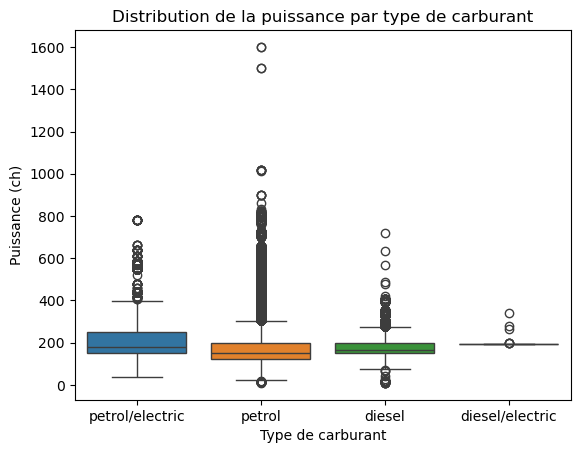

In [128]:
#Visualiser les distributions par type de carburant
sns.boxplot(data=df_cleaned, x='Ft', y='ep (ch)', hue = 'Ft')
plt.title('Distribution de la puissance par type de carburant')
plt.xlabel('Type de carburant')
plt.ylabel('Puissance (ch)')
plt.show()

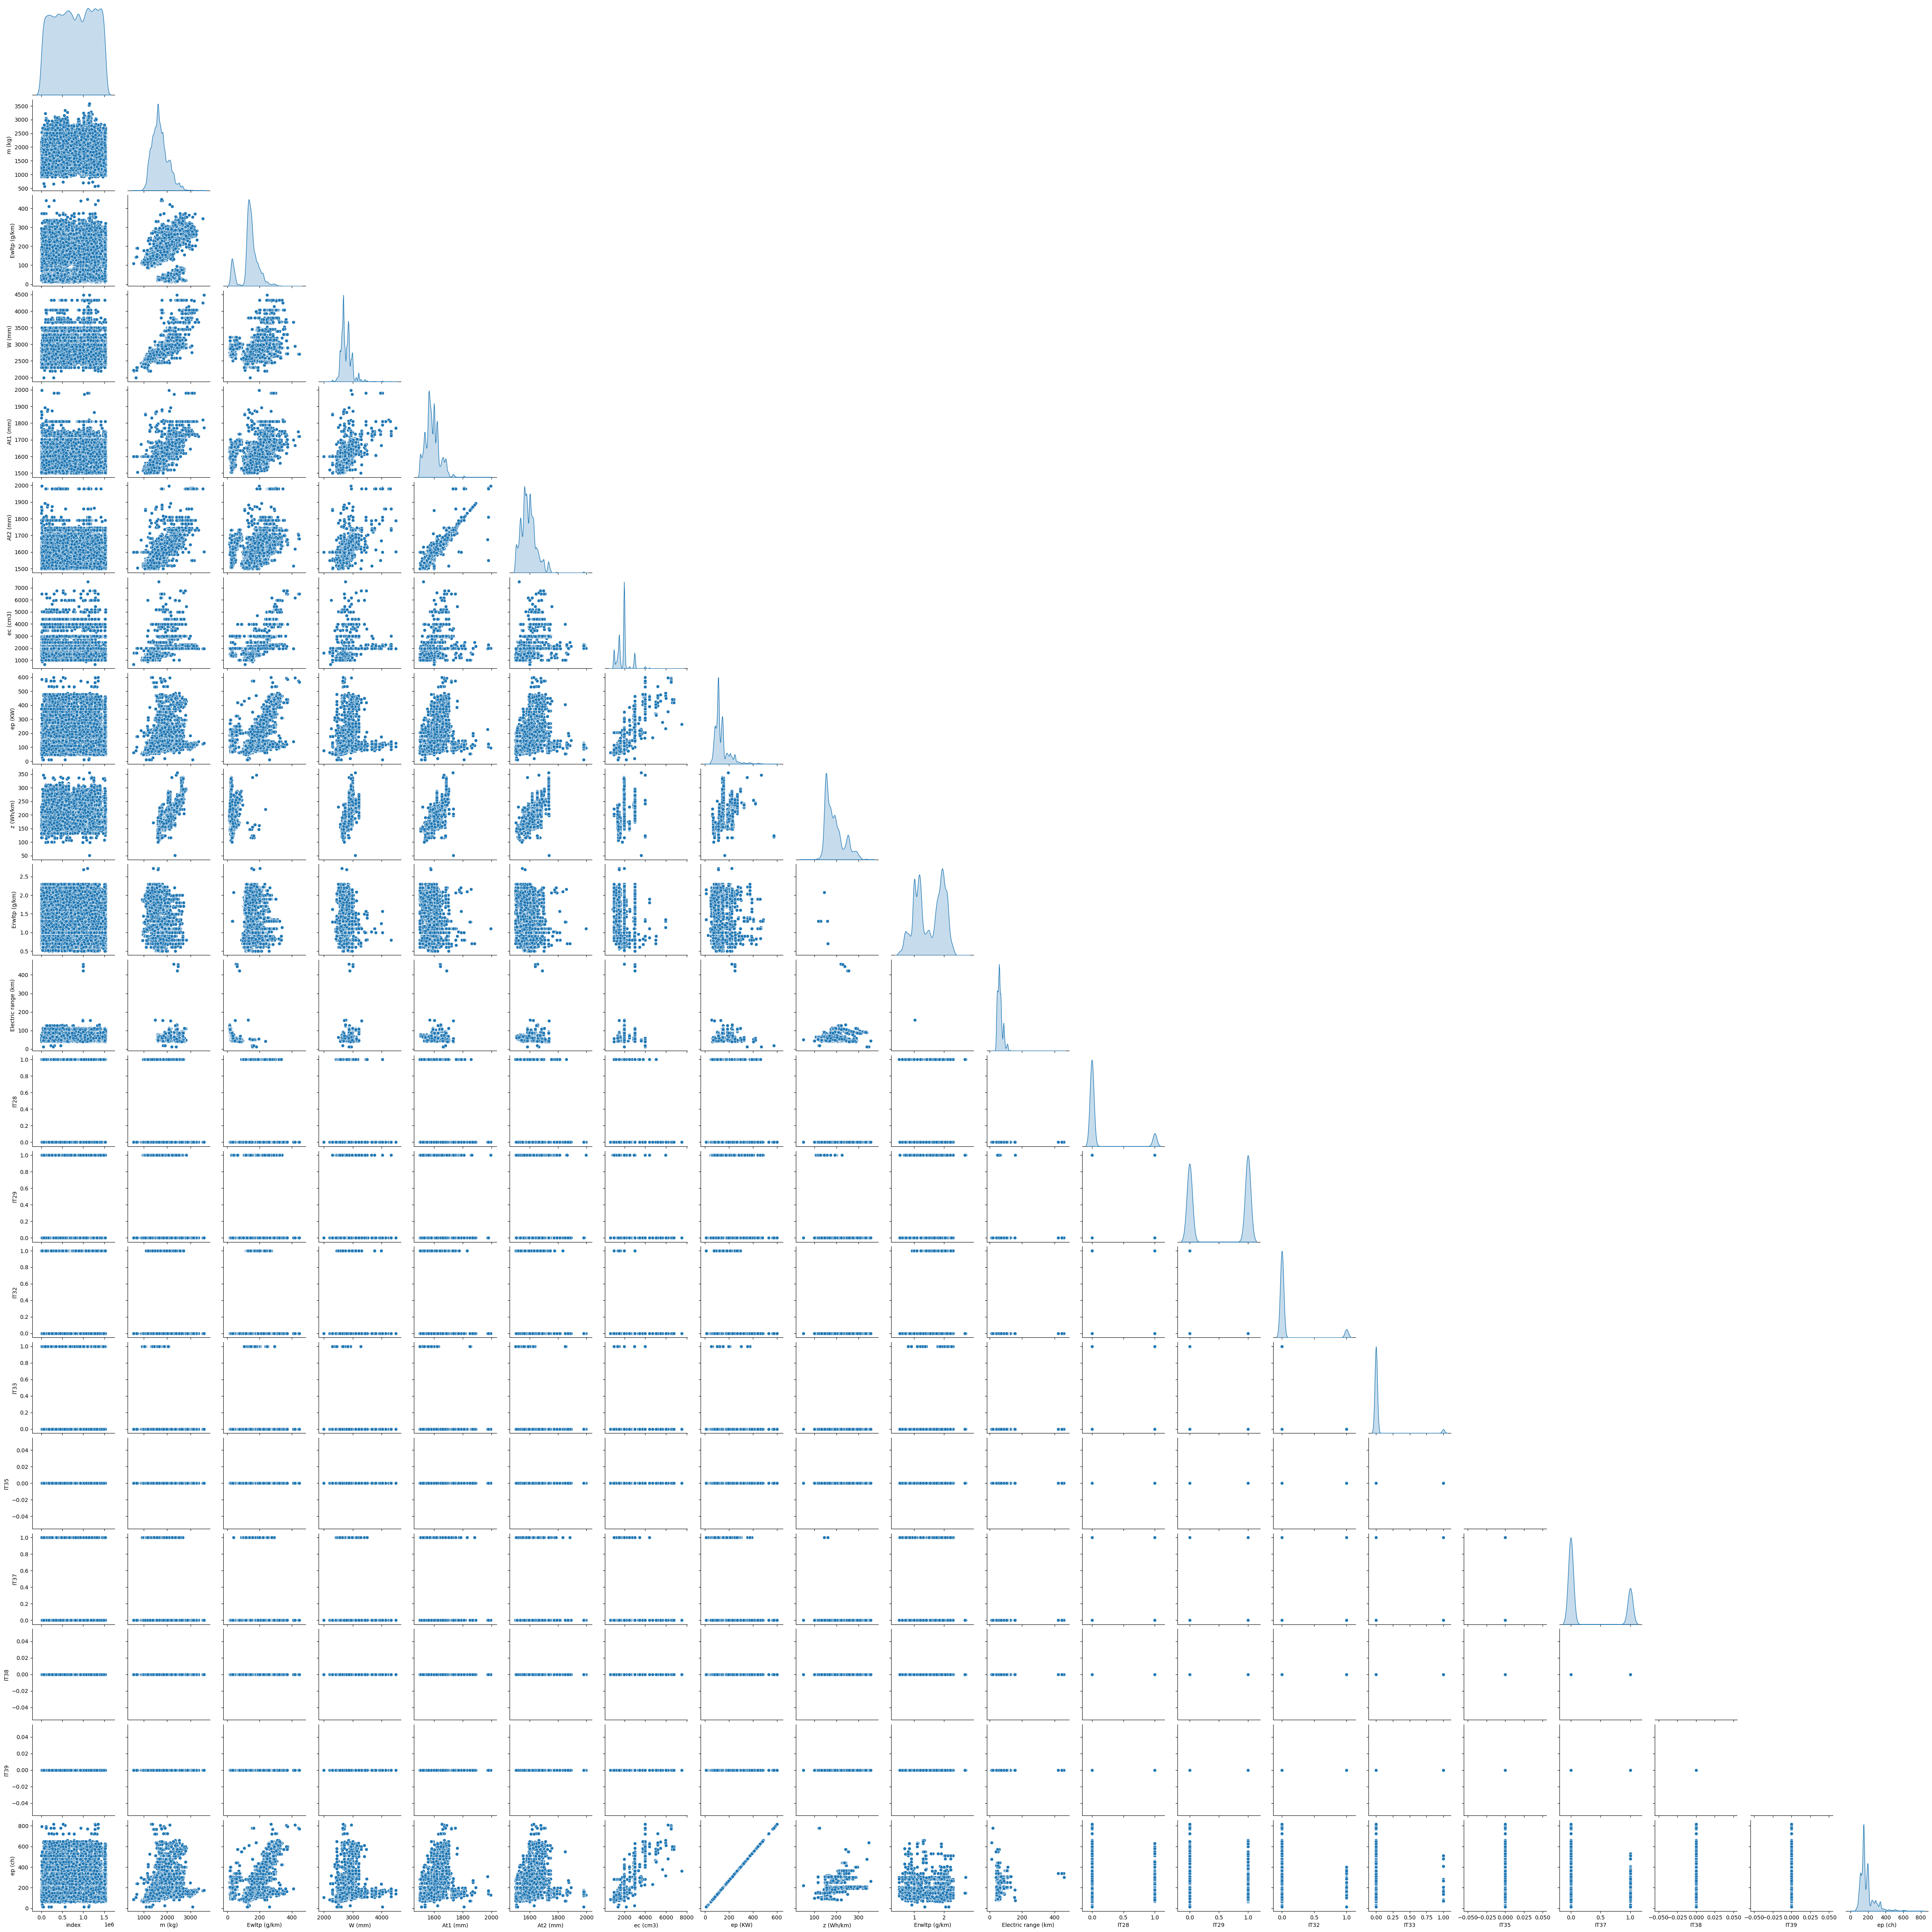

In [129]:

# Prendre un échantillon aléatoire (par exemple 20% des données)
df_sample = df_cleaned.sample(frac=0.1, random_state=42)  # Prendre 10% des données

# alternative pour choisir un nombre spécifique de données aléatoirement:
# df_sample = df_cleaned.sample(n=1000, random_state=42)  # Prendre 1000 lignes aléatoirement

# Créer le pairplot sur l'échantillon
sns.pairplot(df_sample, diag_kind="kde", corner=True)

# Afficher le graphique
plt.show()


In [130]:
df_cleaned.columns

Index(['index', 'Cn', 'Ft', 'Cr', 'm (kg)', 'Ewltp (g/km)', 'W (mm)',
       'At1 (mm)', 'At2 (mm)', 'Fm', 'ec (cm3)', 'ep (KW)', 'z (Wh/km)', 'IT',
       'Erwltp (g/km)', 'Electric range (km)', 'Ft_new', 'IT28', 'IT29',
       'IT32', 'IT33', 'IT35', 'IT37', 'IT38', 'IT39', 'ep (ch)'],
      dtype='object')

In [131]:
# Trier par la colonne 'ep (ch)' (puissance en chevaux) par ordre décroissant
df_cleaned_sorted = df_cleaned.sort_values(by='ep (ch)', ascending=False)

# Afficher les 5 premières lignes pour vérifier
df_cleaned_sorted.head()

,index,Cn,Ft,Cr,m (kg),Ewltp (g/km),W (mm),At1 (mm),At2 (mm),Fm,...,Ft_new,IT28,IT29,IT32,IT33,IT35,IT37,IT38,IT39,ep (ch)
691869,800717,BUGATTI CHIRON SUPER SPORT,petrol,M1,2070.0,487.0,2711.0,1749.0,1661.0,M,...,NaN,0,0,0,0,0,0,0,0,1600.72
895177,1048043,BUGATTI CENTODIECI,petrol,M1,2080.0,487.0,2711.0,1747.0,1670.0,M,...,NaN,0,0,0,0,0,0,0,0,1600.72
1139625,1311591,BUGATTI CHIRON PUR SPORT,petrol,M1,2070.0,572.0,2711.0,1776.0,1695.0,M,...,NaN,0,0,0,0,0,0,0,0,1500.08
169772,199152,BUGATTI CHIRON,petrol,M1,2070.0,572.0,2711.0,1747.0,1670.0,M,...,NaN,0,0,0,0,0,0,0,0,1500.08
1177617,1354758,VALKYRIE,petrol,M1,1435.0,543.0,2770.0,1610.0,1530.0,H,...,NaN,0,0,0,0,0,0,0,0,1015.92


In [132]:
#Vérification des doublons
print(df_cleaned.duplicated(), end='\n\n')

longueur_initiale = len(df)

nb_lignes_dupliquees = df_cleaned.duplicated().sum()

print("Nombre de lignes dupliquées:", nb_lignes_dupliquees)

nb_lignes_dupliquees = df_cleaned.duplicated().sum()

# La fonction drop_duplicates

df_cleaned.drop_duplicates(inplace=True)

longueur_finale = len(df)

print("Nombre de lignes supprimées:", longueur_initiale-longueur_finale)


0          False
1          False
2          False
3          False
4          False
           ...  
1339436    False
1339437    False
1339438    False
1339439    False
1339440    False
Length: 1339350, dtype: bool

Nombre de lignes dupliquées: 0
Nombre de lignes supprimées: 0


In [133]:
object_columns

,Cn,Ft,Cr,Fm,IT,Ft_new
0,MITSUBISHI ECLIPSE CROSS,petrol/electric,M1,P,NaN,NaN
1,TOYOTA AYGO X,petrol/electric,M1,M,NaN,petrol/electric
2,PANDA,petrol,M1,H,e3 33,NaN
3,SPORTAGE,petrol/electric,M1,P,NaN,NaN
4,SPORTAGE,petrol/electric,M1,P,NaN,NaN
...,...,...,...,...,...,...
1339436,GLA 250 4MATIC,petrol,M1,M,e1 29,NaN
1339437,AMG GT 43 4MATIC+,petrol,M1,H,NaN,NaN
1339438,KUGA,petrol,M1,H,NaN,NaN
1339439,X5 xDrive45e,petrol/electric,M1G,P,NaN,NaN


In [134]:
print(df_cleaned.isna().sum())
# Il faut nettoyer toutes les colonnes où il reste des Nan avant d'encoder

index                        0
Cn                        8699
Ft                           0
Cr                          15
m (kg)                      11
Ewltp (g/km)               496
W (mm)                       0
At1 (mm)                     0
At2 (mm)                     0
Fm                           0
ec (cm3)                    25
ep (KW)                      0
z (Wh/km)              1161633
IT                      393951
Erwltp (g/km)           427970
Electric range (km)    1168094
Ft_new                 1332235
IT28                         0
IT29                         0
IT32                         0
IT33                         0
IT35                         0
IT37                         0
IT38                         0
IT39                         0
ep (ch)                      0
dtype: int64


In [135]:
# Sauvegarde des données après mes modifications sur la colonne puissance
#df_cleaned.to_csv(base_processed+'data2022_feature_engineered07_Vincent.csv', index=False)

In [136]:
# vérification hypothèse de corrélation entre At1 et AT2
correlation_pearson = df_cleaned[['At1 (mm)', 'At2 (mm)']].corr(method='pearson')
print(correlation_pearson)

          At1 (mm)  At2 (mm)
At1 (mm)  1.000000  0.888392
At2 (mm)  0.888392  1.000000


In [137]:
correlation_spearman = df_cleaned[['At1 (mm)', 'At2 (mm)']].corr(method='spearman')
print(correlation_spearman)

          At1 (mm)  At2 (mm)
At1 (mm)  1.000000  0.874675
At2 (mm)  0.874675  1.000000


In [138]:
from scipy.stats import pearsonr, spearmanr

pearson_corr, pearson_pval = pearsonr(df_cleaned['At1 (mm)'], df_cleaned['At2 (mm)'])
spearman_corr, spearman_pval = spearmanr(df_cleaned['At1 (mm)'], df_cleaned['At2 (mm)'])

print(f"Pearson: Corr={pearson_corr}, p-value={pearson_pval}")
print(f"Spearman: Corr={spearman_corr}, p-value={spearman_pval}")

Pearson: Corr=0.8883920315222865, p-value=0.0
Spearman: Corr=0.8746750424573784, p-value=0.0


In [139]:
# après avoir vérifié la corrélation entre At1 et At2 on décide de supprimer At2 avec les autres colonnes inutiles du jeu de données
df_cleaned = df_cleaned.drop(columns=['IT', 'Ft_new', 'At2 (mm)', 'Erwltp (g/km)'])

In [140]:
# Avant de passer à l'encodage on supprime les valeurs manquantes des colonnes Cr et m
df_cleaned = df_cleaned.dropna(subset=['Cr', 'm (kg)'])

In [141]:
# On procède maintenant à l'encodage des variables object Ft et Cr
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(drop='first', sparse_output=False)  # Évite la multicolinéarité
encoded = encoder.fit_transform(df_cleaned[['Ft', 'Cr']])

# Convertir en DataFrame et concaténer avec le DataFrame d'origine
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['Ft', 'Cr']))
encoded_df.index = df_cleaned.index
df_cleaned = pd.concat([df_cleaned.drop(columns=['Ft', 'Cr']), encoded_df], axis=1)
print(df_cleaned.shape, encoded_df.shape)

(1339324, 26) (1339324, 6)


In [142]:
print(df_cleaned.isna().sum())

index                        0
Cn                        8699
m (kg)                       0
Ewltp (g/km)               491
W (mm)                       0
At1 (mm)                     0
Fm                           0
ec (cm3)                    25
ep (KW)                      0
z (Wh/km)              1161607
Electric range (km)    1168068
IT28                         0
IT29                         0
IT32                         0
IT33                         0
IT35                         0
IT37                         0
IT38                         0
IT39                         0
ep (ch)                      0
Ft_diesel/electric           0
Ft_petrol                    0
Ft_petrol/electric           0
Cr_M1G                       0
Cr_M1S                       0
Cr_N1G                       0
dtype: int64


In [143]:
df_cleaned.head()

,index,Cn,m (kg),Ewltp (g/km),W (mm),At1 (mm),Fm,ec (cm3),ep (KW),z (Wh/km),...,IT37,IT38,IT39,ep (ch),Ft_diesel/electric,Ft_petrol,Ft_petrol/electric,Cr_M1G,Cr_M1S,Cr_N1G
0,2,MITSUBISHI ECLIPSE CROSS,1975.0,46.0,2670.0,1540.0,P,2360.0,72.0,175.0,...,0,0,0,97.92,0.0,0.0,1.0,0.0,0.0,0.0
1,4,TOYOTA AYGO X,1020.0,108.0,2430.0,1540.0,M,998.0,53.0,NaN,...,0,0,0,72.08,0.0,0.0,1.0,0.0,0.0,0.0
2,5,PANDA,1067.0,112.0,2300.0,1600.0,H,999.0,52.0,NaN,...,0,0,0,70.72,0.0,1.0,0.0,0.0,0.0,0.0
3,8,SPORTAGE,1905.0,25.0,2680.0,1615.0,P,1598.0,132.0,169.0,...,0,0,0,179.52,0.0,0.0,1.0,0.0,0.0,0.0
4,9,SPORTAGE,1905.0,25.0,2680.0,1615.0,P,1598.0,132.0,169.0,...,0,0,0,179.52,0.0,0.0,1.0,0.0,0.0,0.0


In [144]:
# Sauvegarde des données après mes modifications sur la colonne puissance
df_cleaned.to_csv(base_processed+'engineerd1.csv', index=False)

In [145]:
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Temps écoulé : {elapsed_time} secondes')


Temps écoulé : 191.9567403793335 secondes


ubuntu 08/02/2025: Temps écoulé : 
92.45 secondes en power saver
61.83 secondes en performance
  
win 22/02/2025  
191 secondes